<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.955 · Models avançats de mineria de dades · PAC3</p>
<p style="margin: 0; text-align:right;">2021-1 · Màster universitari en Ciència de dades (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Mètodes supervisats

En aquesta pràctica veurem diferents mètodes supervisats i tractarem d'optimitzar diferents mètriques. Veurem com els diferents models classifiquen els punts i amb quins obtenim major precisió. Després aplicarem tot el que hem après fins ara a un dataset nou simulant un cas pràctic real.

1. Exploració d'algorismes supervisats
       1.2. k veïns més propers
       1.3. Support vector machines
       1.4. Arbre de decisió
       1.5. Random forest
       1.5. Gradient boosting
2. Implementació cas pràctic
       2.1. Anàlisi descriptiu
       2.2. Preprocessament de les dades
       2.3. Entrenament d'un model
       2.4. Predicció de casos nous

**Important: Cadascun dels exercicis pot suposar varios minuts d'execució, pel que l'entrega s'ha de fer en format notebook i en format html on es vegi el codi i els resultats, juntament amb els comentaris de cada exercici. Per a exportar el notebook a html es pot fer des del menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nom i cognoms: Jordi Puig Ovejero</strong>
</div>

---

Per a això necessitarem les següents llibreries:

In [1]:
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## 1. Càrrega de dades

El conjunt de dades MOONS consisteix en punts en un pla que formen dues llunes, d'aquí el nom de "moons". Cada lluna correspon a un grup diferent [0, 1].

El següent codi generara 1.000 punts i en farà un gràfic per visualitzar les dues llunes (amb colors diferents per cada grup).

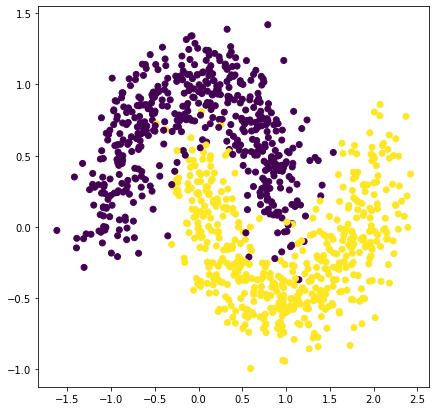

In [2]:
df = make_moons(n_samples=1000, noise=0.2, random_state=2)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)

Abans d'aplicar cap model, hem de separar les dades entre el conjunt de *train* i el conjunt de *test*. Sempre treballarem sobre el conjunt de *train* i evaluarem els resultats en *test*.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Dividiu el <i>dataset</i> en dos subconjunts, <i>train</i> (80% aprox.) i <i>test</i>. Podeu fer servir l'implementació train_test_split de sklearn.
</div>

In [3]:
# creem el dataset
df_pd = pd.DataFrame(list(zip(df_x, df_y, df_group)), columns =['x', 'y', 'class']) 

# generem els subconjunts de train i de test 
X_train, X_test, y_train, y_test = train_test_split(df_pd[["x", "y"]], df_pd['class'], test_size=0.20, random_state=42)

Al llarg dels exercicis apendrem a veure gràficament les fronteres de decisió que ens retornen els diferents models. Per fer això utilitzarem la funció definida a continuació. Aquesta segueix els següents passos:

- Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) amb els valors mínim i màxim de 'x' i 'y'.
- Predir el classificador amb els valors de la *meshgrid*.
- Fer un *reshape* de les dades per tenir el format corresponent.

Un cop fet això ja podem fer el gràfic de les fronteres de decisió i afegir-hi els punts reals.
Així veurem les àrees que el model considera que són d'una classe i les que considera que són d'una altre. Al posar-hi a sobre els punts veurem si els classifica correctament a l'àrea que els correspon. També veurem les areas d'indecisió, casos en els que el model no es decanta ni cap una classe ni cap una altre (o si que es decanta però no ho té 100% clar), aquestes seran blanquinoses.

In [4]:
# Fem la meshgrid amb els valors màxim i mínim de 'x' i 'y'.
x_min, x_max = df_pd['x'].min()-0.1, df_pd['x'].max()+0.1
y_min, y_max = df_pd['y'].min()-0.1, df_pd['y'].max()+0.1  

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predim el classifier amb els valors de la meshgrid.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Fem reshape per tenir el format correcte.
    Z = Z.reshape(xx.shape)

    # Seleccionem una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Fem el gràfic de les fronteres de decisió.
    fig, ax = plt.subplots(figsize=(16,16))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Afegim els punts.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)
    
    return ax

### 1.1 $k$ veïns més propers (1 punt)

El primer algoritme que utilitzarem per a classificar els punts és el $k$-nn. En aquest exercici ajustarem dos hiperparàmetres del algoritme per tal d'intentar obtenir una major precisió:

- $k$: el número de veïns que es consideren per a classificar un nou exemple. Provarem amb tots els valors entre 1 i 10.
- pesos: importància que es dona a cadascun dels veïns considerats. En aquest cas provarem amb dues opcions: pesos uniformes, on tots els veïns es consideren igual; i pesos segons distància, on els veïns més propers tenen més pes en la classificació que els veïns més llunyans.

Per a decidir quins són els hiperparàmetres òptims utilitzarem una cerca de reixeta (*grid search*), és a dir, entrenarem un model per a cada combinació de hiperparàmetres possible i l'evaluarem utilitzant validació creuada (*cross validation*) amb 4 particions estratificades. Posteriorment, triarem la combinació d'hiperparàmetres que millors resultats hagi obtingut.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> càlcul del valor òptim dels hiperparàmetres <i>k</i> i <i>pesos</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i KNeighborsClassifier de sklearn.
</div>

In [5]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = KNeighborsClassifier()

# Definim els hiperparàmetres
hiperparameters = [{'n_neighbors': [1,2,3,4,5,6,7,8,9,10], 'weights': ['uniform','distance']}]


# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()
print("Grid de scores:")
print()
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Millor score: 0.97
Millor estimador: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
Millors paràmetres: {'n_neighbors': 3, 'weights': 'uniform'}

Grid de scores:

0.956 (+/-0.029) for {'n_neighbors': 1, 'weights': 'uniform'}
0.956 (+/-0.029) for {'n_neighbors': 1, 'weights': 'distance'}
0.962 (+/-0.025) for {'n_neighbors': 2, 'weights': 'uniform'}
0.956 (+/-0.029) for {'n_neighbors': 2, 'weights': 'distance'}
0.970 (+/-0.010) for {'n_neighbors': 3, 'weights': 'uniform'}
0.961 (+/-0.015) for {'n_neighbors': 3, 'weights': 'distance'}
0.966 (+/-0.016) for {'n_neighbors': 4, 'weights': 'uniform'}
0.964 (+/-0.013) for {'n_neighbors': 4, 'weights': 'distance'}
0.967 (+/-0.018) for {'n_neighbors': 5, 'weights': 'uniform'}
0.964 (+/-0.015) for {'n_neighbors': 5, 'weights': 'distance'}
0.970 (+/-0.014) for {'n_neighbors': 6, 'weights': 'uniform'}
0.969 (+/-

Implementem una funció que reutilitzarem per tal de mostrar el heatmap a partir de l'objecte Grid que retorna la classe GridSearchCV. En el heatmap tenim un dels hiperparàmetres en l'eix X i l'altre en l'eix Y, i els valors de la matriu és el mean_test_score. En quant al mapa de colors quan més blanc millors valors. 

In [6]:
def plot_heatmap_from_grid(grid):

    params = [k for k in grid.cv_results_.keys() if k.startswith('param_')]
    if len(params) != 2: raise Exception('el grid no té exactament 2 paràmetres.') 

    index = params[0]
    columns = params[1]
    values = 'mean_test_score'

    df_dict = {k: grid.cv_results_[k] for k in grid.cv_results_.keys() & {index, columns, values}}

    df = pd.DataFrame(df_dict)
    data = df.pivot(index=index, columns=columns, values=values)
    
    fig, ax = plt.subplots(figsize=(16,16))
    ax.figure.axes[-1].set_ylabel('', size=16)
    sns.heatmap(data, annot=True, fmt='.3f', ax=ax)

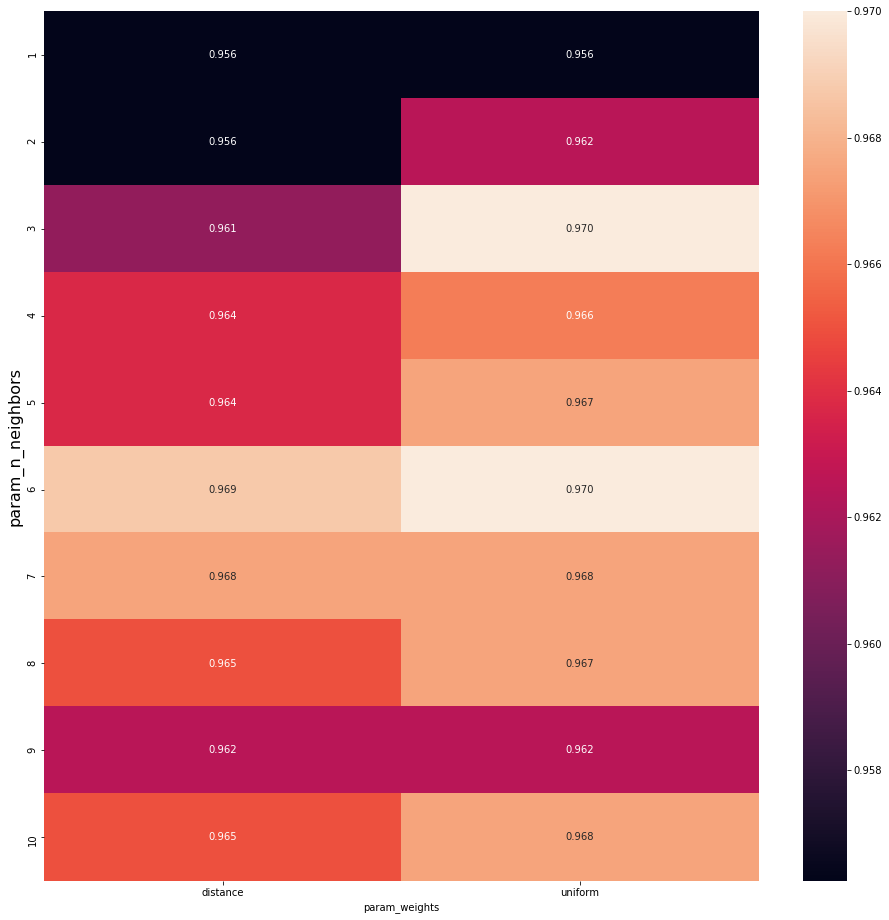

In [7]:
plot_heatmap_from_grid(grid)

Segons els càlculs realitzats amb la classe GridSearchCV, el millor estimador ha estat amb una K de 3 elements i fent servir pesos uniformes. Però si revissem tots els element veiem que el valor de K = 6 té el mateix score. En ambdós casos la qualitat de la predicció és molt bona.

Fem un plot i mostrem l'accuracy amb cada un dels K per cada una de les forma de mesurar els pesos dels elements (uniform i distance).

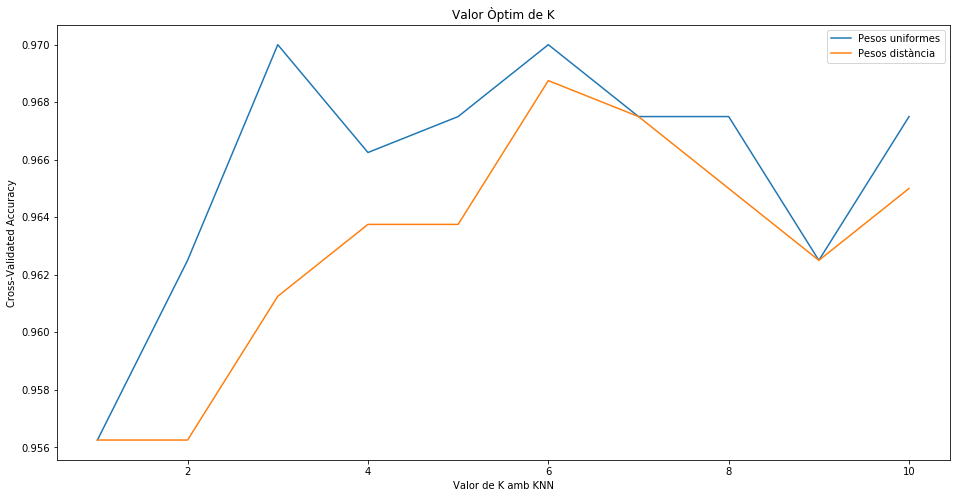

In [8]:
# Valors de 1 al 10
k_range = range(1, 11)

# Valors de accuracy dels models
k_scores_uniform = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    scores = cross_val_score(knn, X_train, y_train, cv=4)
    k_scores_uniform.append(scores.mean())

plt.figure(figsize=(16,8))
plt.plot(k_range, k_scores_uniform)
plt.title('Valor Òptim de K amb Uniform Distance')
plt.xlabel('Valor de K amb KNN')
plt.ylabel('Cross-Validated Accuracy')

k_scores_uniform = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
    scores = cross_val_score(knn, X_train, y_train, cv=4)
    k_scores_uniform.append(scores.mean())

plt.plot(k_range, k_scores_uniform)
plt.title('Valor Òptim de K')
plt.xlabel('Valor de K amb KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.legend(['Pesos uniformes','Pesos distància'])
plt.show()

Podem comprovar que el resultat és el mateix i que el millor valor de K és de 3 amb pesos uniformes utilitzant com a mesura l'accuracy. Encara que el valor de 6 també seria un bon valor de K.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el <i>dataset</i> de test, i calculeu l'<i>accuracy</i> i la matriu de confusió. 
</div>

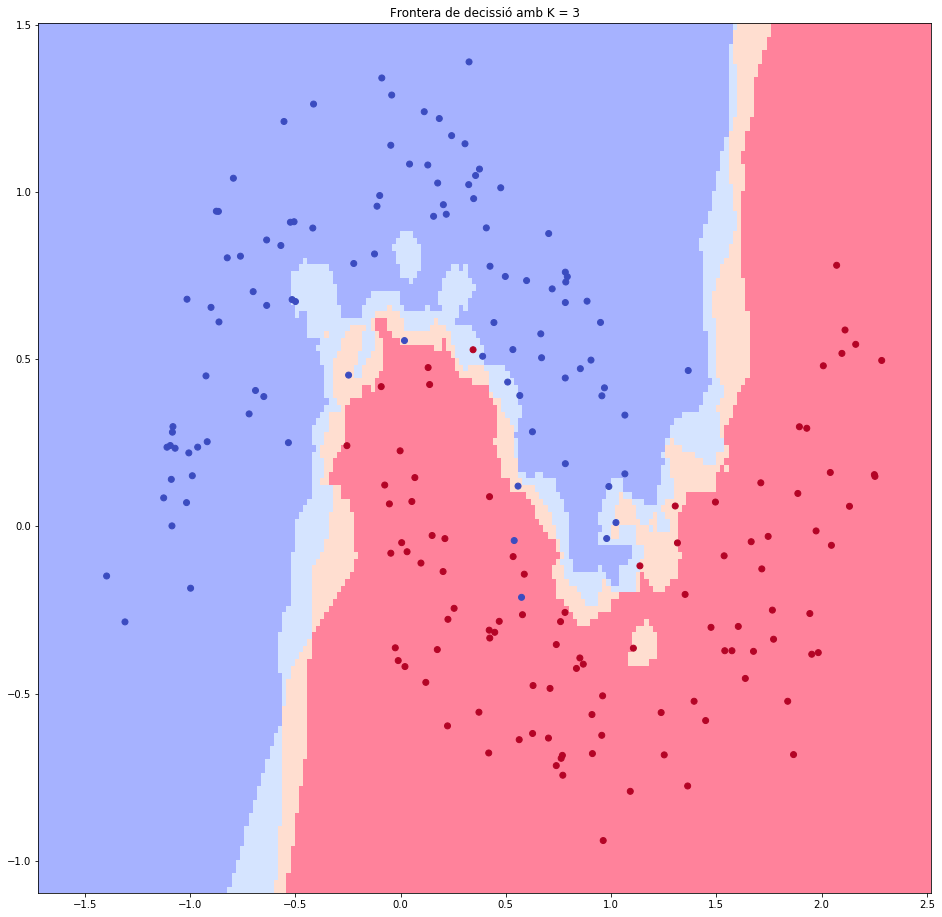

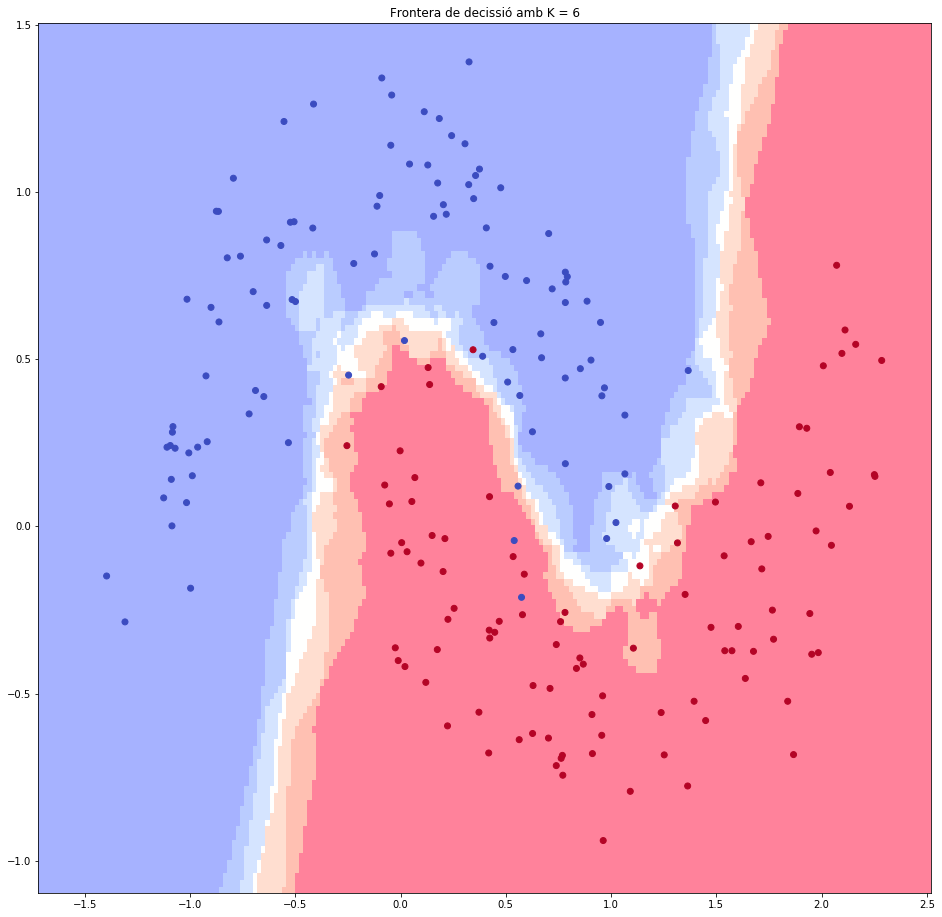

In [9]:
model_3 = KNeighborsClassifier(n_neighbors=3, weights='uniform')
model_3.fit(X_train, y_train)
ax_3 = plot_decision_boundaries(x=X_test['x'], 
                                y=X_test['y'],
                                labels=y_test.astype('int'),
                                model=model_3,
                                x_min=x_min, 
                                x_max=x_max, 
                                y_min=y_min,
                                y_max=y_max)   
ax_3.set_title('Frontera de decissió amb K = 3')


model_6 = KNeighborsClassifier(n_neighbors=6, weights='uniform')
model_6.fit(X_train, y_train)
ax_6 = plot_decision_boundaries(x=X_test['x'], 
                                y=X_test['y'],
                                labels=y_test.astype('int'),
                                model=model_6,
                                x_min=x_min, 
                                x_max=x_max, 
                                y_min=y_min,
                                y_max=y_max)   
ax_6.set_title('Frontera de decissió amb K = 6')

print()

In [10]:
y_prediction = model_6.predict(X_test)
print(confusion_matrix(y_test,y_prediction))
print(classification_report(y_test, y_prediction))

y_prediction = model_3.predict(X_test)
print(confusion_matrix(y_test,y_prediction))
print(classification_report(y_test, y_prediction))


[[96  4]
 [ 2 98]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       100
           1       0.96      0.98      0.97       100

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

[[95  5]
 [ 2 98]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           1       0.95      0.98      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

Visualment veiem que tant amb K = 3 com amb K = 6 l'algoritme és capaç de traçar un marge de confiança prou clar i per tant li és relativament fàcil classificar elements nous. És un algoritme que encara que sigui simple, amb aquesta distribució d'elements treballa molt bé. Està clar que hi ha una serie d'elements que no aconsegueix classificar però que realment es poden considerar com "outliers" de la classe, ja que és troben dins del grup de l'altre classe i és practicament impossible predir-los de forma correcta. Però el que és interessant respecte aquests elements és que no generen soroll i no afectan a la resta d'elements i els classifica bé. En ambdós casos tenim uns talls relativament regulars (ja que hi han talls més rectes) i zones de color més clar on la predicció no seria tant evident. Amb k = 6 tenim unes zones blanques que serien zones d'indecissió, no sabria que classificar d'entrada.

En quant a la predicció realitzada amb les dades de test tenim millor accuracy amb K = 3 però per un element únicament.

El problema amb aquest algoritme seria amb grans quantitats de dades ja que no crea un model a l'entrenament sino que treballa amb totes les dades per cada classificació i això penalitza el rendiment. No és el cas.

### 1.2. Support Vector Machines (1 punt)

En aquest segon exercici classificarem els punts utilitzant l'algoritme SVM amb el *kernel* radial. Tornarem a utilitzar una cerca de reixeta (*grid search*). En aquest cas els hiperparàmetres a optimitzar són:

- C: és la regularització, és a dir, el valor de penalització dels errors en la classificació. Indica el compromís entre obtenir l'hiperpla amb el marge més gran possible i classificar el màxim número d'exemples correctament. Provarem els valors: 0.01, 0.1, 1, 10, 50, 100 i 200.
- gamma: coeficient que multiplica la distància entre dos punts al kernel radial. Per dir-ho a "grosso modo", com més petit és gamma, més influencia tenen dos punts propers. Provarem els valors: 0.001, 0.01, 0.1, 1 i 10.

Igual que en el cas anterior, per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>C</i> i <i>gamma</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòdul GridSearchCV i svm de sklearn.
</div>

In [11]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = svm.SVC()

# Definim els hiperparàmetres
hiperparameters = [{'C': [0.01,0.1,1,10,50,100,200], 'gamma': [0.001,0.01,0.1,1,10]}]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()
print("Grid de scores:")
print()
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Millor score: 0.96875
Millor estimador: SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
Millors paràmetres: {'C': 1, 'gamma': 1}

Grid de scores:

0.785 (+/-0.022) for {'C': 0.01, 'gamma': 0.001}
0.786 (+/-0.026) for {'C': 0.01, 'gamma': 0.01}
0.794 (+/-0.022) for {'C': 0.01, 'gamma': 0.1}
0.871 (+/-0.054) for {'C': 0.01, 'gamma': 1}
0.964 (+/-0.025) for {'C': 0.01, 'gamma': 10}
0.785 (+/-0.022) for {'C': 0.1, 'gamma': 0.001}
0.789 (+/-0.022) for {'C': 0.1, 'gamma': 0.01}
0.829 (+/-0.033) for {'C': 0.1, 'gamma': 0.1}
0.955 (+/-0.014) for {'C': 0.1, 'gamma': 1}
0.968 (+/-0.021) for {'C': 0.1, 'gamma': 10}
0.790 (+/-0.021) for {'C': 1, 'gamma': 0.001}
0.831 (+/-0.029) for {'C': 1, 'gamma': 0.01}
0.874 (+/-0.043) for {'C': 1, 'gamma': 0.1}
0.969 (+/-0.008) for {'C': 1, 'gamma': 1}
0.966 (+/-0.008) 

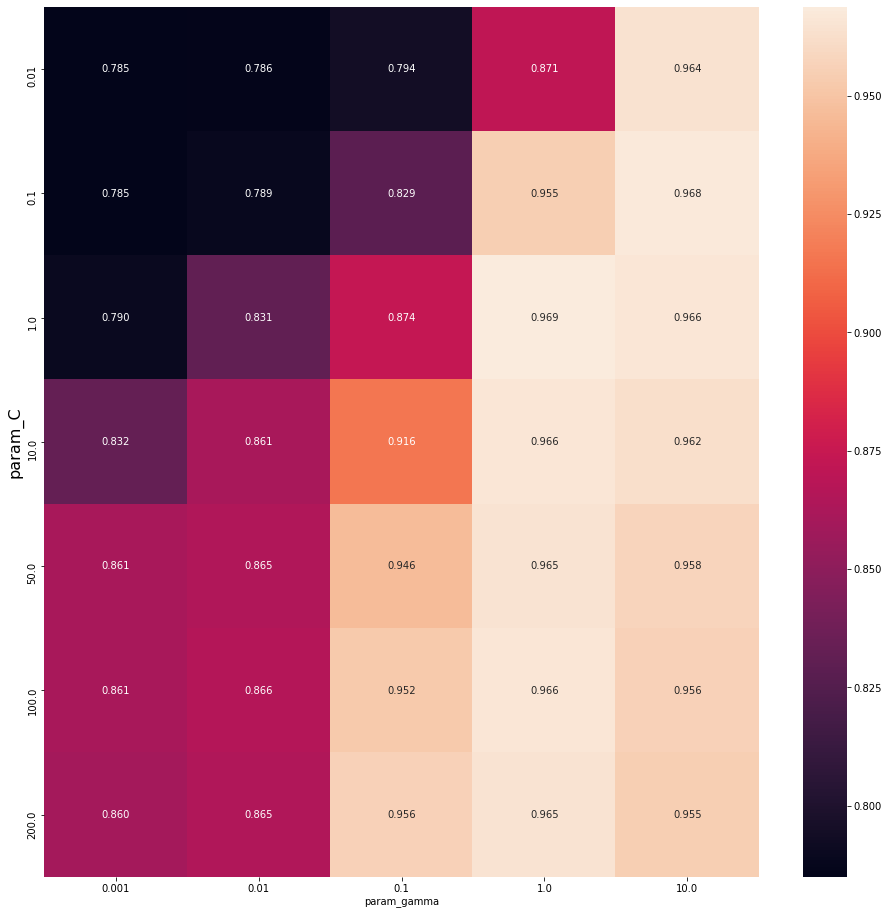

In [12]:
plot_heatmap_from_grid(grid)

En aquest cas amb l'algoritme de SVD fem servir com a funció Kernel una funció radial. La funció radial (rbf - Radial Basis Function) és la que ve per defecte, per tant no l'afegim a la matriu d'hiperparàmetres.

El valor de C, que és comú a totes les funcions Kernel, serveix per a penalitzar els punts malament classificats i així definir el marge. Si C és petit, la penalització per punts mal classificats es baixa, per tant el marge pot ser més gran també. Si C és gran, SVM minimitza el nombre d'exemples mal classificats amb un marge més petit. La penalització no és igual per a tots els exemples mal classificats. Depén de la distància al límit de decisió, com més llunyà més penalització.

El paràmetre Gamma controla la distància de la influència dels punts d'entrenament. Valors baixos de gamma indiquen un gran radi de similitud que dóna com a resultat que s'agrupin més punts. En canvi amb valors alts els punts han d'estar molt a prop entre si per ser considerats al mateix grup (o classe). Els models amb valors gamma molt grans tendeixen a sobreajustar-se o sobreentrenament. 

En el nostre cas els millors valors han estat amb una gamma de 1 y C també de 1, encara que amb gamma de 0.1 y C de 10 també tenim molt bons valors.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el <i>dataset</i> de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

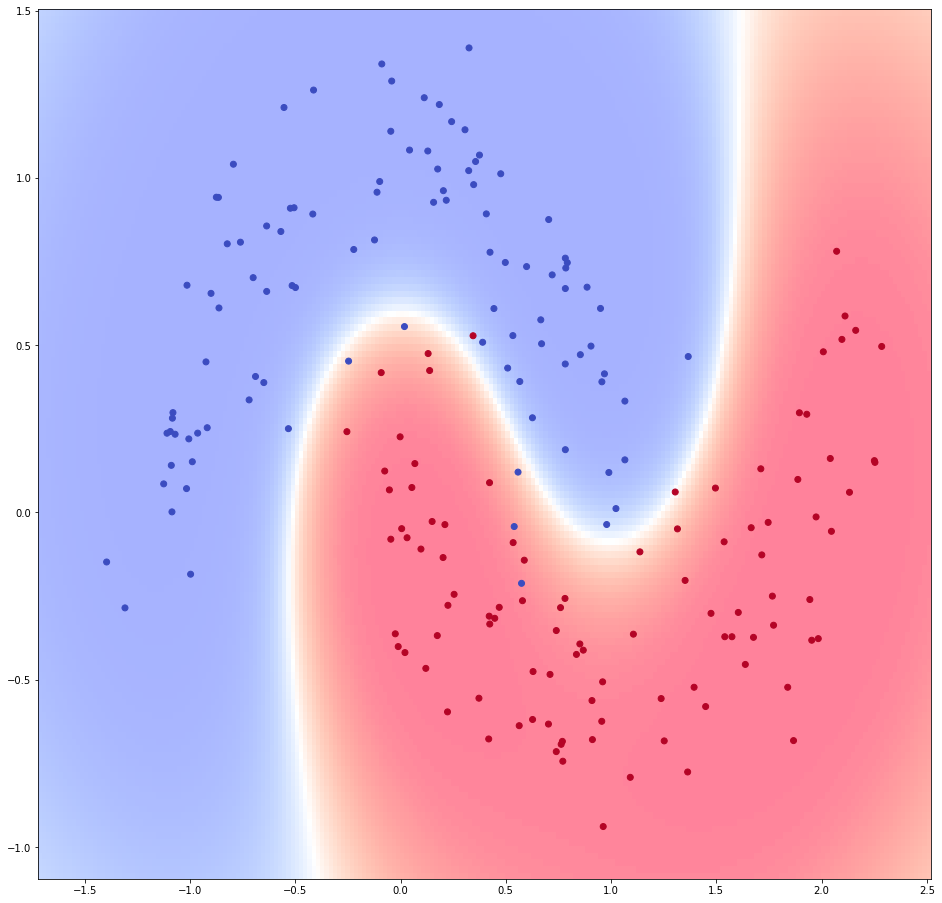

In [13]:
model = svm.SVC(C=1, gamma=1, probability=True)
model = model.fit(X_train, y_train)
ax_6 = plot_decision_boundaries(x=X_test['x'], 
                                y=X_test['y'],
                                labels=y_test.astype('int'),
                                model=model,
                                x_min=x_min, 
                                x_max=x_max, 
                                y_min=y_min,
                                y_max=y_max)  

In [14]:
y_true, y_pred = y_test, grid.predict(X_test)
print(confusion_matrix(y_test,y_prediction))
print(classification_report(y_true, y_pred))
print()

[[95  5]
 [ 2 98]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           1       0.95      0.98      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200




<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

En aquest cas estem fent servir un algoritme on el que es busca és maximitzar el marge entre els punts a classificar. Com podem veure es crea una frontera de decissió molt ben definida encara que veiem alguns punt que cauen malament per els "outliers" de la classe que cauen dins de l'altre classe. Tenim el que es coneix com soft-margin, no tots els punts estan en el costat correcte. De totes formes, les dades són clarament separables.

Però el que realment fa molt bé es marcar la línea divisoria o marge per classificar que és la potencia d'aquest algoritme. És una línea totalment lineal i regular. Nous elements són molt fàcils de classificar. L'espai en blanc que no sap definir al final és el que cerca l'algoritme que és maximitzar el marge (o terra de ningú) on no hauria de caure cap punt.

No s'aprofita tota la potencia de l'algoritme ja que pot treballar amb moltes dimensions i no és el nostre cas.

### 1.3. Arbres de decisió (1 punt)

En aquest tercer exercici classificarem els punts utilitzant un arbre de decisió. Utilitzarem com abans una cerca de reixeta (*grid search*) per ajustar els hiperparàmetres. En aquest cas ajustarem els següents:

- max_depth: la profunditat màxima de l'arbre. Explorarem els valors entre 4 i 10. 
- min_samples_split: el mínim nombre d'observacions que ha de tenir una fulla de l'arbre per poder-se dividir. Explorarem els valors: 2, 10, 20, 50 i 100.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>max_depth</i> i <i>min_samples_split</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i DecisionTreeClassifier de sklearn.
</div>

In [15]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = DecisionTreeClassifier()

# Definim els hiperparàmetres
hiperparameters = [{'max_depth': [4,5,6,7,8,9,10], 'min_samples_split': [2,10,20,50,100]}]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()
print("Grid de scores:")
print()
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Millor score: 0.9537499999999999
Millor estimador: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Millors paràmetres: {'max_depth': 8, 'min_samples_split': 2}

Grid de scores:

0.907 (+/-0.033) for {'max_depth': 4, 'min_samples_split': 2}
0.907 (+/-0.033) for {'max_depth': 4, 'min_samples_split': 10}
0.907 (+/-0.033) for {'max_depth': 4, 'min_samples_split': 20}
0.906 (+/-0.037) for {'max_depth': 4, 'min_samples_split': 50}
0.906 (+/-0.038) for {'max_depth': 4, 'min_samples_split': 100}
0.950 (+/-0.030) for {'max_depth': 5, 'min_samples_split': 2}
0.950 (+/-0.030) for {'max_depth': 5, 'min_samples_split': 10}
0.950 

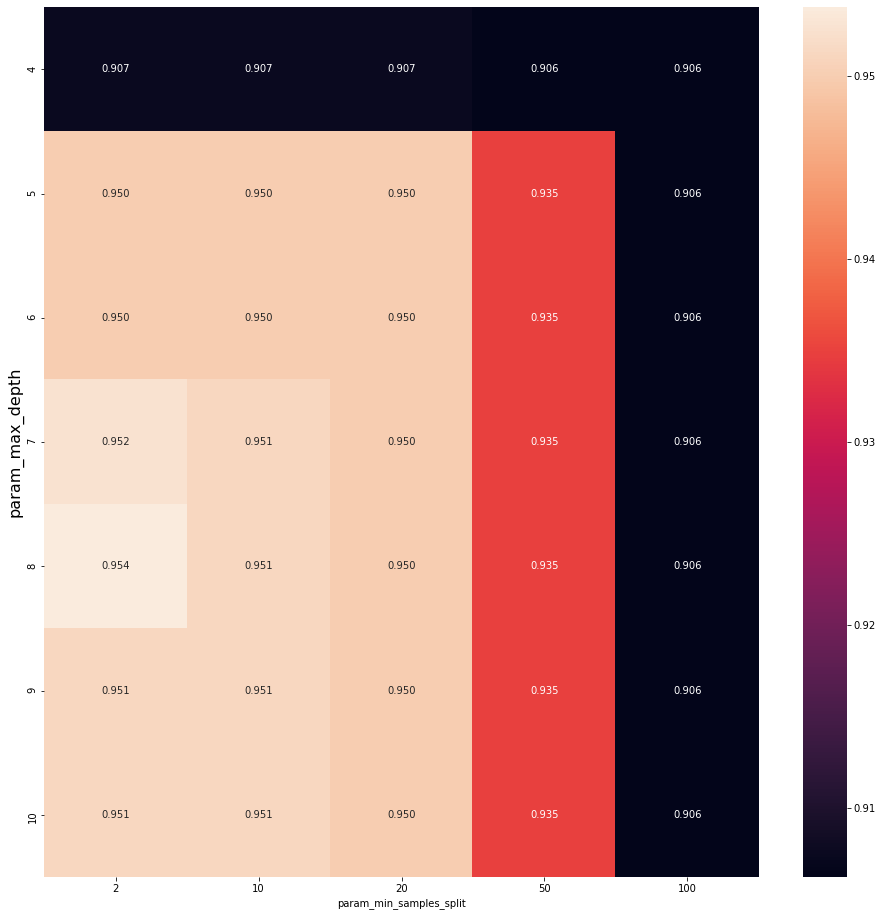

In [16]:
plot_heatmap_from_grid(grid)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'accuracy i la matriu de confusió.
</div>

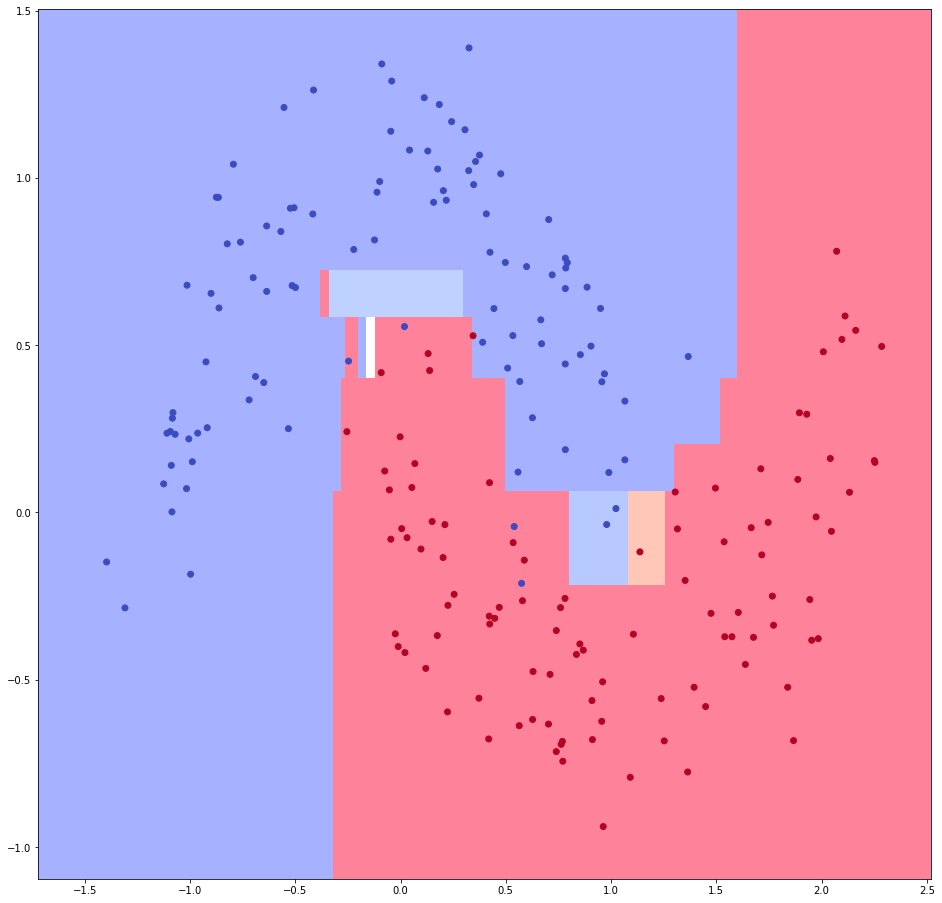

In [17]:
model = DecisionTreeClassifier(max_depth=8, min_samples_split=2)
model = model.fit(X_train, y_train)
plot_decision_boundaries(x=X_test['x'], 
                                y=X_test['y'],
                                labels=y_test.astype('int'),
                                model=model,
                                x_min=x_min, 
                                x_max=x_max, 
                                y_min=y_min,
                                y_max=y_max)  
print()

In [18]:
y_true, y_pred = y_test, grid.predict(X_test)
print(confusion_matrix(y_test,y_prediction))
print(classification_report(y_true, y_pred))
print()

[[95  5]
 [ 2 98]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       100
           1       0.96      0.96      0.96       100

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200




<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

Els resultat de la predicció és molt similar als altres algoritmes. El que sí que és molt diferent és la frontera de decissió ja que té una forma molt més plana o amb talls rectes. No tenim zones d'indecissió i les zones més clares o menys evidents no són masses exteses. Com amb la resta dels algoritmes, tenim elements qué es prediuen malament. 

El que fa l'algoritme és delimitar zones segons valors de X-Y i allà defineix una frontera (aquesta frontera és una condició en l'arbre). Per exemple, quan X = -0.35 (aprox.) traça una frontera i per sota o per sobre és una classe o una altre (des de y = 0 fins a y = 0.4). Així va delimitant el plànol i teixint alhora un arbre mitjançant les condicions.

### 1.4. Random forest (1 punt)

En aquest quart punt classificarem els punts utilitzant un Random forest. Utilitzarem, com fins ara, una cerca de reixeta (*grid search*) per ajustar els hiperparàmetres i ajustarem:

- max_depth: la profunditat màxima de l'arbre. Explorarem els valors entre 6 i 12. 
- n_estimators: nombre d'arbres. Explorarem els valors: 10, 50, 100 i 200.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>max_depth</i> i <i>n_estimators</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i RandomForestClassifier de sklearn.
</div>

In [19]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = RandomForestClassifier()

# Definim els hiperparàmetres
hiperparameters = [{'max_depth': [6,7,8,9,10,11,12], 'n_estimators': [10,50,100,200]}]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()
print("Grid de scores:")
print()
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Millor score: 0.96375
Millor estimador: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Millors paràmetres: {'max_depth': 12, 'n_estimators': 200}

Grid de scores:

0.956 (+/-0.040) for {'max_depth': 6, 'n_estimators': 10}
0.958 (+/-0.032) for {'max_depth': 6, 'n_estimators': 50}
0.958 (+/-0.034) for {'max_depth': 6, 'n_estimators': 100}
0.956 (+/-0.033) for {'max_depth': 6, 'n_estimators': 200}
0.955 (+/-0.024) for {'max_depth': 7, 'n_estimators': 10}
0.961 (+/-0.030) for {'max_depth': 7, 'n_estim

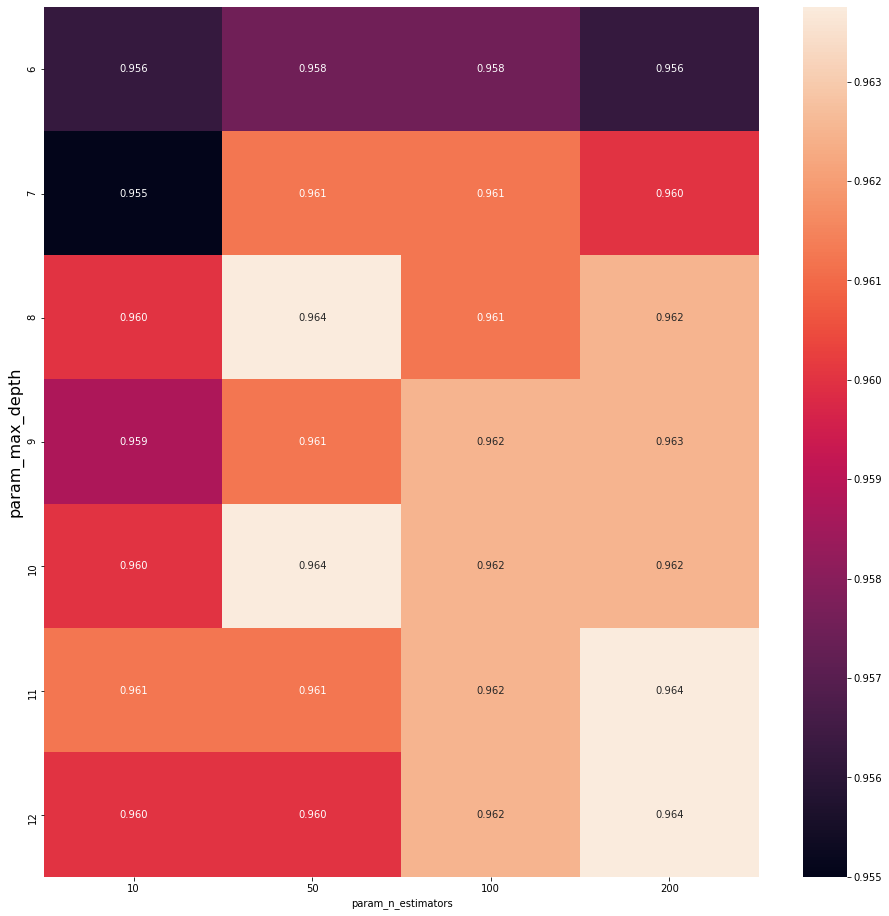

In [20]:
plot_heatmap_from_grid(grid)

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

Random Forest és un derivat dels arbres de decissió que genera un "bosc" d'arbres. És a dir, per el conjunt d'entrenament genera diferents variants amb subconjunts del dataset de training i d'aquesta forma és dona oportunitat a dades que potser quedarian "eclipsades" a tenir un pes en el resultat. El resultat de la classificació serà la suma dels resultats de cada subarbre, és a dir de tot el bosc. En regressió, agafarà el promig de tots els arbres.

Els hiperparàmetres que fem servir són n_estimators, que són el nombre d'arbres del bosc i max_depth que és la profunditat màxima de l'arbre. El millor resultat ha anat variant força en diferents execucions. Agafarem n_estimators = 200, max_depth = 12

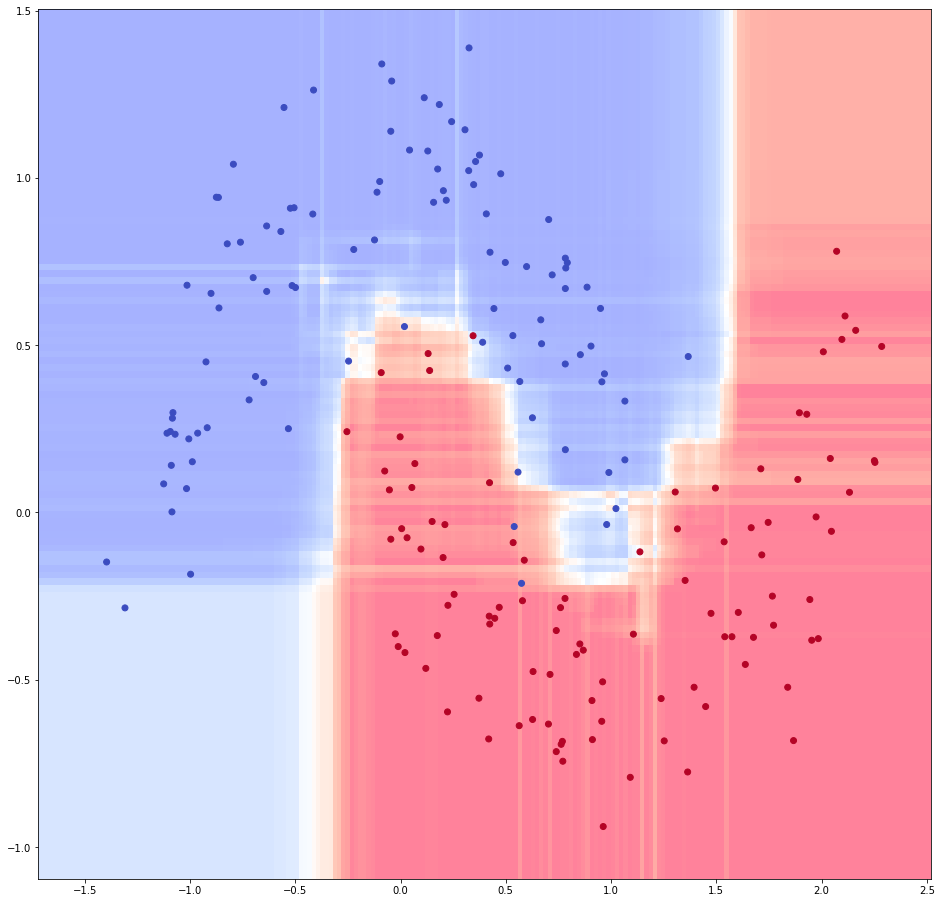

In [21]:
model = RandomForestClassifier(max_depth=12, n_estimators=200)
model = model.fit(X_train, y_train)
plot_decision_boundaries(x=X_test['x'], 
                                y=X_test['y'],
                                labels=y_test.astype('int'),
                                model=model,
                                x_min=x_min, 
                                x_max=x_max, 
                                y_min=y_min,
                                y_max=y_max)  
print()

In [22]:
y_true, y_pred = y_test, grid.predict(X_test)
print(confusion_matrix(y_test,y_prediction))
print(classification_report(y_true, y_pred))
print()

[[95  5]
 [ 2 98]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       100
           1       0.95      0.99      0.97       100

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200




<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

Aquest algoritme intenta buscar dades que no quedin tapades per altres dades i donar oportunitat a tot el dataset de train a que tingui pes en la classificació.

El resultat de la frontera de decissió és semblant a l'arbre de classificació de l'exercici previ però no són tan rectes els talls i tenen zones més regulars. A més també tenim més zones blanques d'indeterminació força grans i perpendiculars a tot el mapa. 

Els punts quedan ben classificats, a excepció dels elements barrejats entre classes que ja hem comentat repetidament. Però a primera vista sembla com si el resultat de l'algoritme, veient la frontera i les zones, tingués un comportament extrany. Hi han zones d'indecissió (zona blanca) on hauria de ser clarament un color ben definit.

### 1.5. Gradient boosting (1 punt)

En aquest exercici classificarem els punts utilitzant un Gradient boosting. Utilitzarem com fins ara una cerca de reixeta (*grid search*) per ajustar els següents hiperparàmetres:

- learning_rate: velocitat d'aprenentatge, si el valor és molt alt correm el risc que explori massa i no trobi cap òptim, mentre que si el valor és molt baix pot tardar molt en convergir i estancar-se en un mínim local. Explorarem els valors: 0.01, 0.1, 1 i 2. 
- n_estimators: nombre d'arbres. Explorarem els valors: 10, 50, 100 i 200.

Igual que en els cas anterior, utilitzarem validació creuada (*cross-validation*) amb 4 particions estratificades per validar el rendiment de l'algoritme amb cada combinació d'hiperparàmetres.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Càlcul del valor òptim dels hiperparàmetres <i>learning_rate</i> i <i>n_estimators</i>. Feu un <i>heatmap</i> per visualitzar les precisions segons els dos hiperparàmetres. Podeu utilitzar els mòduls GridSearchCV i GradientBoostingClassifier de sklearn.
</div>

In [23]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = GradientBoostingClassifier()

# Definim els hiperparàmetres
hiperparameters = [{'learning_rate': [0.01,0.1,1,2], 'n_estimators': [10,50,100,200]}]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()
print("Grid de scores:")
print()
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Millor score: 0.9612499999999999
Millor estimador: GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Millors paràmetres: {'learning_rate': 0.1, 'n_estimators': 200}

Grid de scores:

0.906 (+/-0.038) for {'learning_rate': 0.01, 'n_estimators': 10}
0.906 (+/-0.038) for {'learning_rate': 0.01, 'n_estimators': 50}
0.906 (+/-0.038) for {'learning_rate': 0

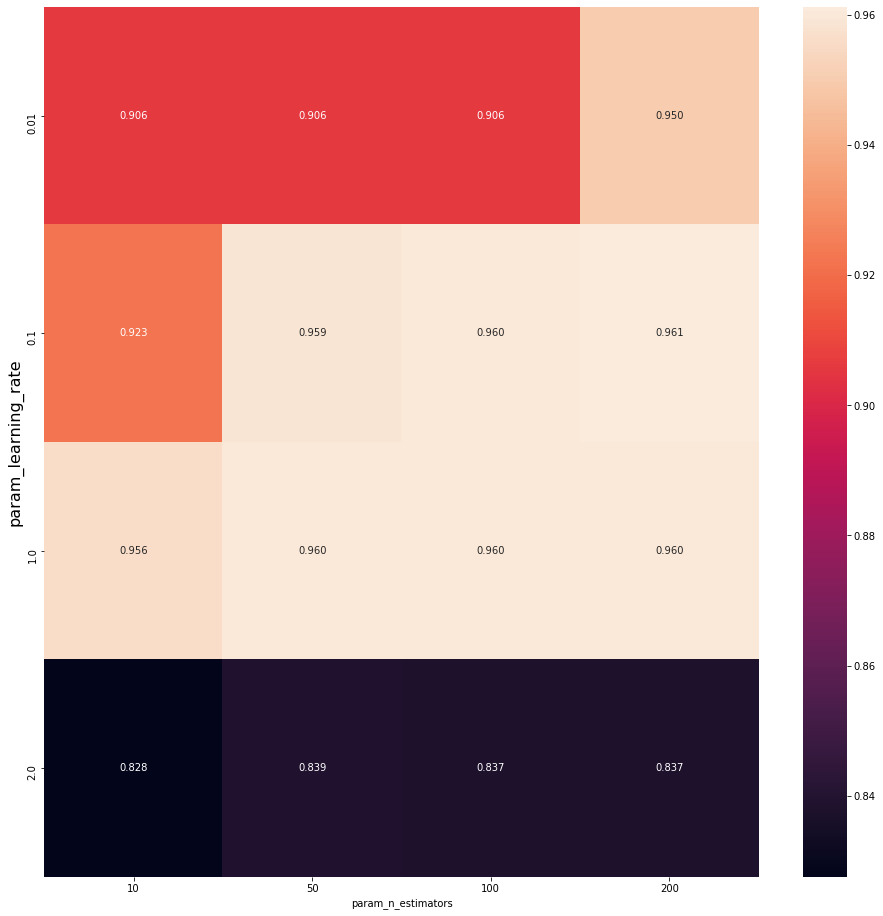

In [24]:
plot_heatmap_from_grid(grid)

Gradient Boosting també és un derivat dels arbres de decissió. Tambe treballa amb diferents arbres però en aquest cas els arbres es generen de forma seqüencial de forma que el següent arbre corretgeix l'error produït per l'anterior i va modificant el model general. Va fent una aprenentatge progressiu corretjin l'error amb els diferents arbres. És similar al descens de gradient de les xarxes neuronals.

Els hiperparàmetres que fem servir són n_estimators, que són el nombre d'arbres del model i learning_rate que és la velocitat d'aprenentatge. Quant més lent l'aprenentatge tenim un millor model, més robust i eficient però el processament pot ser massa lent. Aquest lent rendiment es pot compensar amb el nombre d'arbres a fer servir.

Tenim una franja entre learning_rate [0.1, 1] i n_estimators [50, 200] on els resultats són força similars. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Pels hiperparàmetres amb major precisió, representeu gràficament la frontera de decisió amb el dataset de test, i calculeu l'<i>accuracy</i> i la matriu de confusió.
</div>

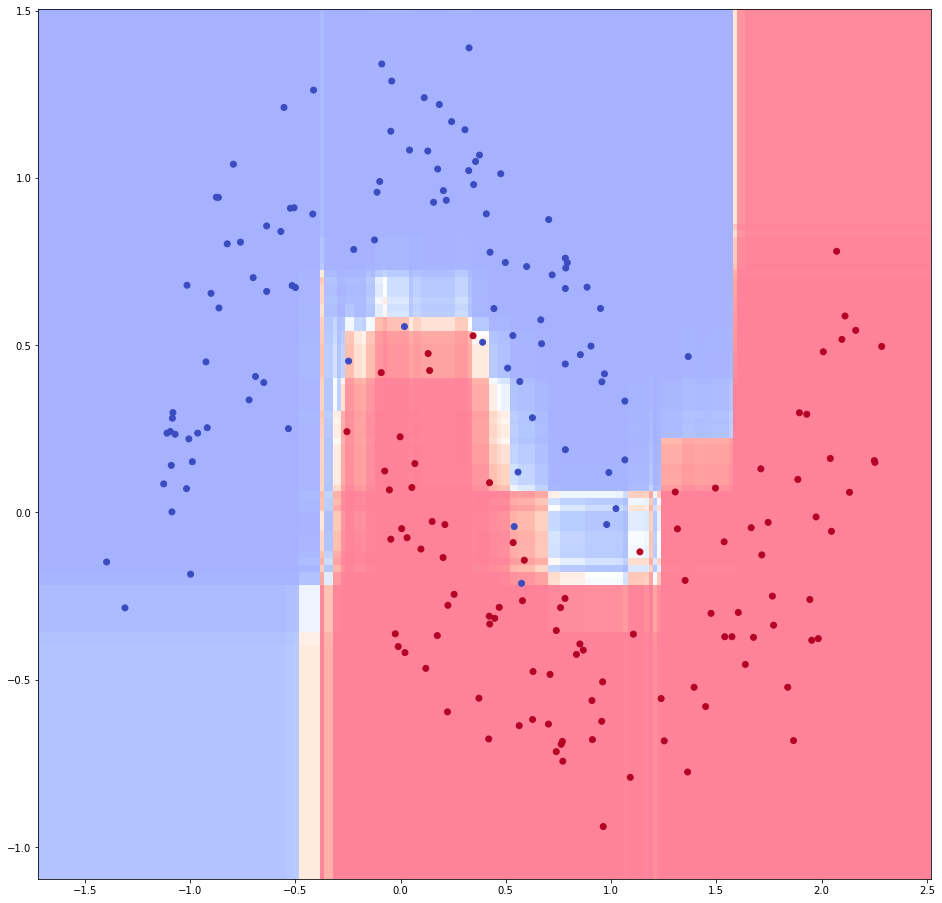

In [25]:
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)
model = model.fit(X_train, y_train)
plot_decision_boundaries(x=X_test['x'], 
                                y=X_test['y'],
                                labels=y_test.astype('int'),
                                model=model,
                                x_min=x_min, 
                                x_max=x_max, 
                                y_min=y_min,
                                y_max=y_max)  
print()

In [26]:
y_true, y_pred = y_test, grid.predict(X_test)
print(confusion_matrix(y_test,y_prediction))
print(classification_report(y_true, y_pred))
print()

[[95  5]
 [ 2 98]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           1       0.95      0.98      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200




<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Analitzeu els resultats obtinguts i en especial la frontera de descisió.
</div>

El resultat de la frontera de decissió és semblant Random Forest però són més rectes els límits o no són tan regulars i tenim menys zones blanques o no definides i també tenim menys zones difuses. És a dir, l'algoritme té força més clar quin resultat té cada zona que no pas Ramdom Forest. És probable que l'aprenentatge o correcció dels errors provoquin aquest comportament.

En aquest cas els punts també quedan ben calssificats a excepció dels elements barrejats entre classes.

# 2. Implementació cas pràctic (5 punts)

Ara que ja entenem com funcionen alguns models, anem a aplicar-ho a un cas pràctic. El primer exercici s'ha fet amb una variable target categòrica, per aquest exercici en farem servir una de numèrica. És a dir treballarem amb una regressió, no una classificació.

Utilitzarem un conjunt de dades públic de preus de vivendes a Taiwan amb l'objectiu de trobar les millors ofertes del mercat. La descripció completa del conjunt de dades la podem trobar en el següent enllaç:  https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Comencem carregant les dades en un DataFrame de pandas:

In [27]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") és un identificador numèric de la mostra. Les columnes "*Xn ...*" són els diferents atributs descriptius. Finalment, la columna "*Y ...*" és el valor objetiu o preu de la vivenda.

Extraiem del *DataFrame* la variable objetiu i els atributs descriptius que utilitzarem posteriorment al model predictiu:

In [28]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

### 2.1. Anàlisi descriptiu
Quan se'ns proporciona un dataset, abans de començar a fer res, és molt important fer un anàlisi exploratori per coneixer les dades amb les que treballarem.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Analitzar gràficament la distribució de totes les variables (features i target). Recordeu que les variables categòriques es representen amb gràfics de barres, mentres que les numèriques es representen amb histogrames.
</div>

Hem carregat les dades i veiem els 5 atributs d'entrada que farem servir per a cada una de les vivendes:

    - X2 house age (edat de l'edifici en anys)
    - X3 distance to the nearest MRT station (distància a l'estació de metro més propera en metres)
    - X4 number of convenience stores (nombre de botigues properes) 
    - X5 latitude (coordenada geogràfica)
    - X6 longitude (coordenada geogràfica)
    
La variable de sortida:

    - Y house price of unit area (preu per unitat d'area)

Tots els valors són numèrics i en principi no farem cap transformació amb ells ja que ens van bé per fer les prediccions que volem fer. Podem potser discretitzar l'atribut n_stores, veiem més endavant. 

Per a facilitar el naming dels atributs anem a fer uns renames i així no treballem amb string tan llargs. També fem una previsualitzció:

In [29]:
X_ren = X.rename(columns={'X2 house age': 'age'})
X_ren = X_ren.rename(columns={'X3 distance to the nearest MRT station': 'station_distance'})
X_ren = X_ren.rename(columns={'X4 number of convenience stores': 'n_stores'})
X_ren = X_ren.rename(columns={'X5 latitude': 'latitude'})
X_ren = X_ren.rename(columns={'X6 longitude': 'longitude'})

y_ren = y.to_frame()

y_ren = y_ren.rename(columns={'Y house price of unit area': 'y_price'})

pd.set_option('display.width', 1000)
print(X_ren.join(y_ren).describe())

              age  station_distance    n_stores    latitude   longitude     y_price
count  414.000000        414.000000  414.000000  414.000000  414.000000  414.000000
mean    17.712560       1083.885689    4.094203   24.969030  121.533361   37.980193
std     11.392485       1262.109595    2.945562    0.012410    0.015347   13.606488
min      0.000000         23.382840    0.000000   24.932070  121.473530    7.600000
25%      9.025000        289.324800    1.000000   24.963000  121.528085   27.700000
50%     16.100000        492.231300    4.000000   24.971100  121.538630   38.450000
75%     28.150000       1454.279000    6.000000   24.977455  121.543305   46.600000
max     43.800000       6488.021000   10.000000   25.014590  121.566270  117.500000


Observacions:

    - Tenim 414 registres en total. 
    - La mitjana d'antiguitat de les vivendes és de 17.71 i tenim valors de 0.
    - La mitjana de distància a l'estació de metro propera és del voltant del kilometre.
    - La mitjana de botigues és de 4 aprox. però en tenim que alguna que no té cap.
    - El preu mitja és de 37.98 per unitat d'area.
    
Podem visualitzar les distribucions de cada un dels atributs y de la sortida:

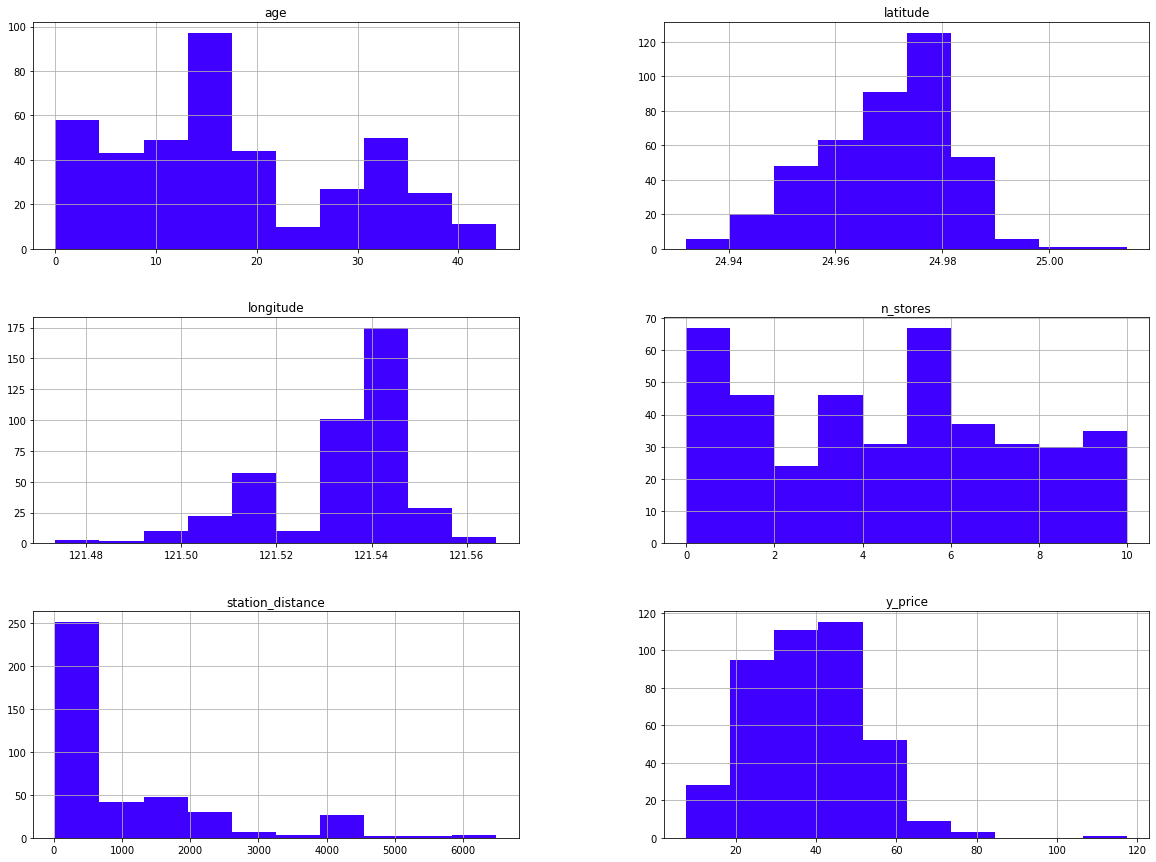

In [30]:
plt_means = X_ren.join(y_ren).iloc[:,:6].hist(figsize = (20,15), color='#3F00FF')

Observacions:

    - En quant a les distribucions podem dir que no s'aprecia una distribució normal en alguns dels artibuts com per exemple n_stores o age. Altres com station_distance podria ser logarítimica-normal i la resta si que ho semblan.
    - L'edat on tenim més elements és al voltant dels 15 anys i tenim algún edifici amb 0 anys (poden ser nous?)
    - El nombre de botigues és relativament igual variable entre 0 i 10.
    - En quant a la distància a una estació propera totes están relativament aprop pero podriem tenir algun outlier.
    - Longitude i latitude no són dades que poden donar molta informació excepte algun valor més allunyat.
    - El preu si que mostre una distribució visualment normal i podem tenir algun valor extrem (o fora de preu de mercat).

### 2.2. Preprocessament de les dades

Un cop fet un primer anàlisi, es tracta de "netejar" el dataset (les features) i adaptar-lo a les nostres necessitats (en aquest cas, predir el preu d'una vivenda).

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Comprova si hi ha null values. En cas d'haver-n'hi, elimina les files corresponents.
</div>

Comprovem tant per les variables 'X' com la sortida 'y' si tenim valors null (NaN):


In [31]:
print('No tenim valors null al dataset amb atributs d\'entrada X. Valors null: ' + str(X.isnull().values.any()))
print('No tenim valors null al dataset amb atribut de sortida y. Valors null: ' + str(y.isnull().values.any()))
print('No cal que esborrem doncs cap registre.')

No tenim valors null al dataset amb atributs d'entrada X. Valors null: False
No tenim valors null al dataset amb atribut de sortida y. Valors null: False
No cal que esborrem doncs cap registre.


El següent pas seria veure la correlació entre totes les features numèriques. Això es fa per assegurar que no hi han dues variables molt relacionades entre elles, ja que en tal cas seria convenient seleccionar una de les dues o combinar-les en una de nova.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Mostra la correlació entre totes les features numèriques. Si n'hi ha dues amb una correlació superior al 90%, elimina'n una de les dues.
    
Pots utilitzar heatmap, de seaborn, per veure-les en un mapa de colors.
</div>

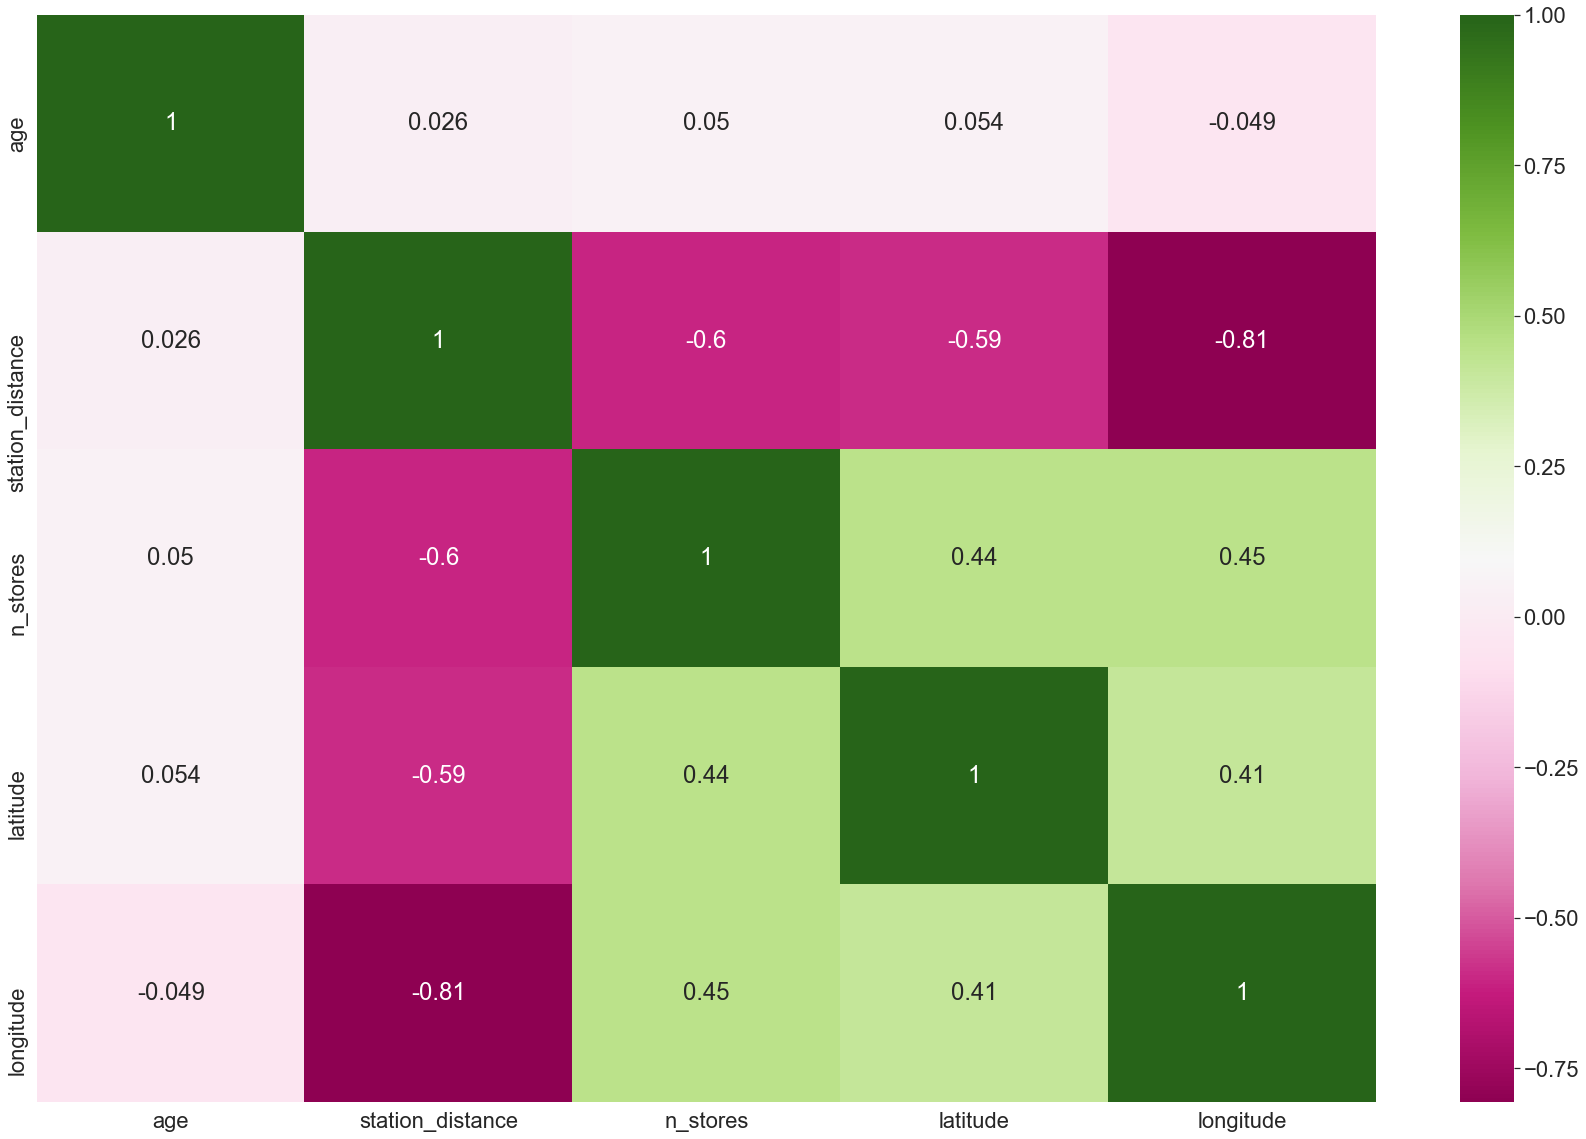

In [76]:
correlation_matrix = X_ren.corr()
plt.figure(figsize=(30,20))
sns.heatmap(correlation_matrix, annot = True, cmap="PiYG")

sns.set(font_scale=1.8)
plt.show()

No tenim cap atribut fortament correlacionat amb els altres. El que més relació tenen és station_distance amb longitude. Segurament hi hauran estacions de metro a una longitude concreta. 

**Per tant farem servir totes les variables que tenim.**  

Ja tenim les variables finals amb les que treballarem. Anem a observar ara quina és la relació de cadascuna d'elles amb el target. 

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Realitza varis scatterplots creuant els diferents atributs amb la variable target. S'ha de realitzar un scatterplot per atribut.
</div>

Ara anem a veure la distribució de la sortida en funció de les entrades. Visualment podem veure quina incidència té cada variable amb la sortida.

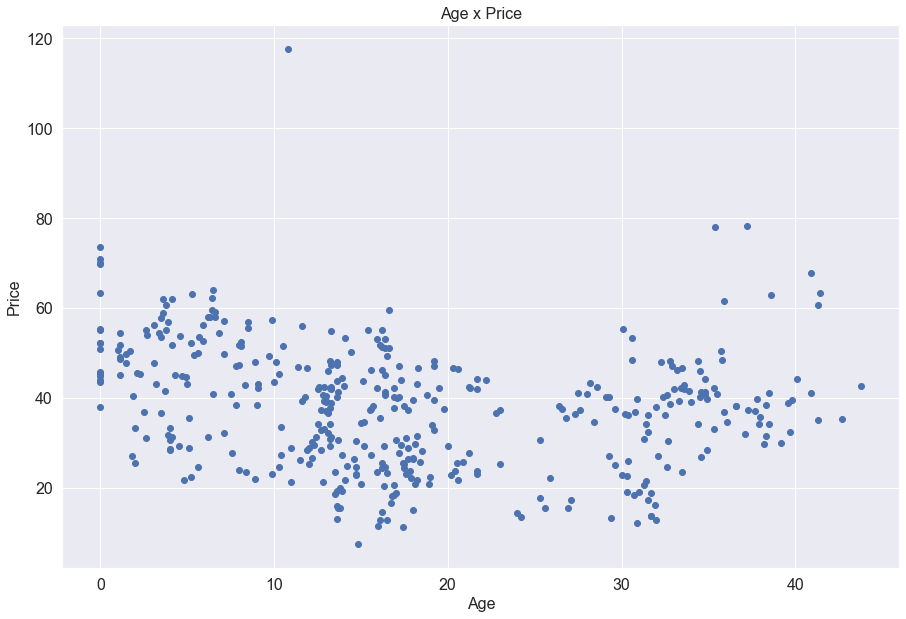

In [33]:
# començem per l'edat
plt.figure(figsize=(15,10))
plt.scatter(x=X_ren['age'], y=y_ren['y_price'])
plt.xlabel('Age', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Age x Price', fontsize=16)
plt.show()

Visualment no sembla que tinguem una relació molt directe entre l'edat de l'edifici i el preu.

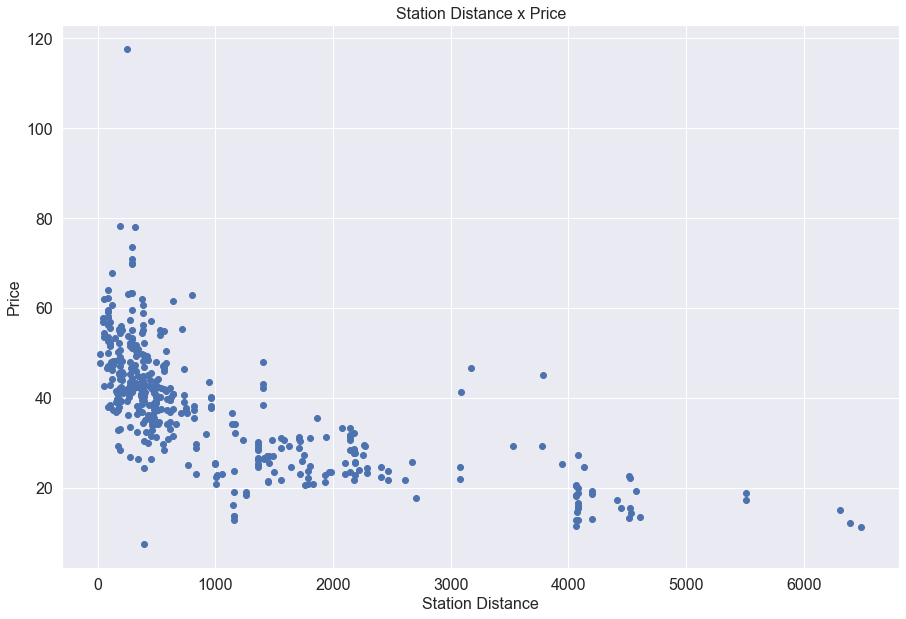

In [34]:
# fem la distància a estació propera
plt.figure(figsize=(15,10))
plt.scatter(x=X_ren['station_distance'], y=y_ren['y_price'])
plt.xlabel('Station Distance', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Station Distance x Price', fontsize=16)
plt.show()

La comunicació si que sembla un factor molt important. Com més aprop tenim una estació de metro més cars són les vivendes.

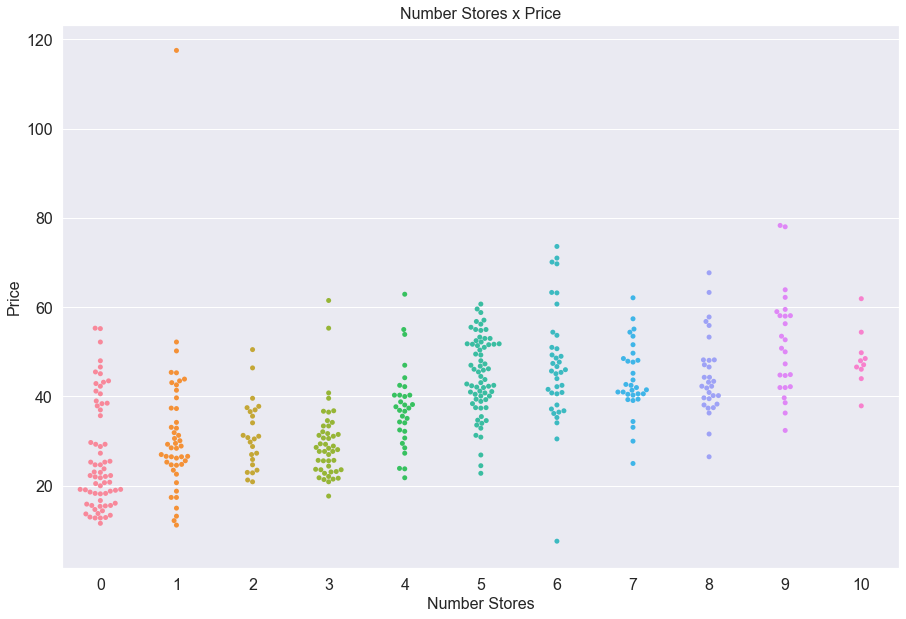

In [35]:
new_data = X_ren.join(y_ren)
new_data['n_stores'] = new_data['n_stores'].astype(int)
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
sns.swarmplot(x="n_stores", y="y_price", data=new_data)
plt.xlabel('Number Stores', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Number Stores x Price', fontsize=16)
plt.show()

Amb el nombre d'establiment també veiem una tendència a l'alça en el preu de les vivendes.

Per comprovar la incidencia de la localització geogràfica farem un plot en 3D (latitude x longitude x price):

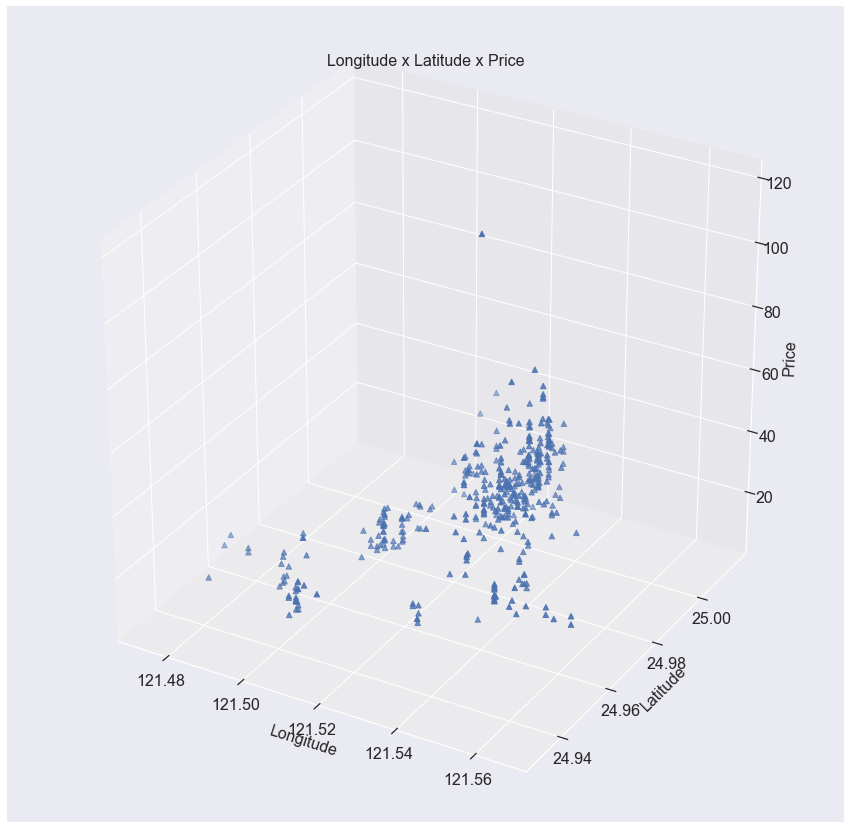

In [36]:
fig = plt.figure(figsize=(15,15))
 
# projecció en 3D
ax = plt.axes(projection ='3d')
 
 # plotting
ax.scatter(new_data['longitude'], new_data['latitude'], new_data['y_price'], marker='^',label='B', s=30)
ax.set_title('Longitude x Latitude x Price', fontsize=16)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.set_zlabel('Price', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

També veiem una relació directe entre la ubicacio de les vivendes en l'espai i el preu dels pisos. 

Podem mostrar-ho en 2D per la multiplicació de la latitude x longitude normalitzada entre 0 i 1. Veiem una mica el mateix. Hi ha una zona entre el valor 0.5 i 0.7 on els preus dels pisos són més cars.

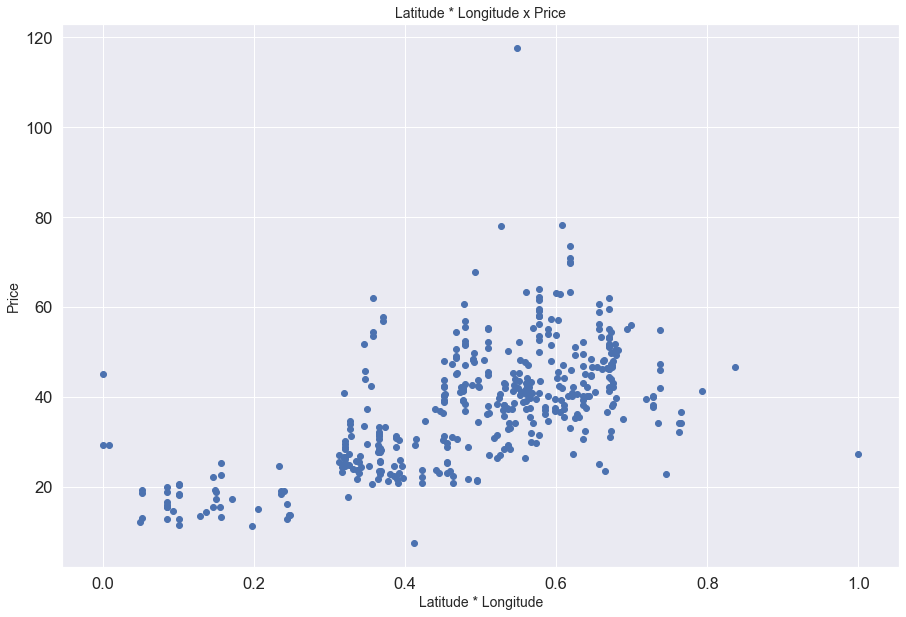

In [37]:
# fem la distància a estació propera
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

plt.figure(figsize=(15,10))
plt.scatter(x= NormalizeData(X_ren['latitude'] * X_ren['longitude']), y=y_ren['y_price'])
plt.xlabel('Latitude * Longitude', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Latitude * Longitude x Price', fontsize=14)
plt.show()

I finalment fem per separat la longitude i latitude: 

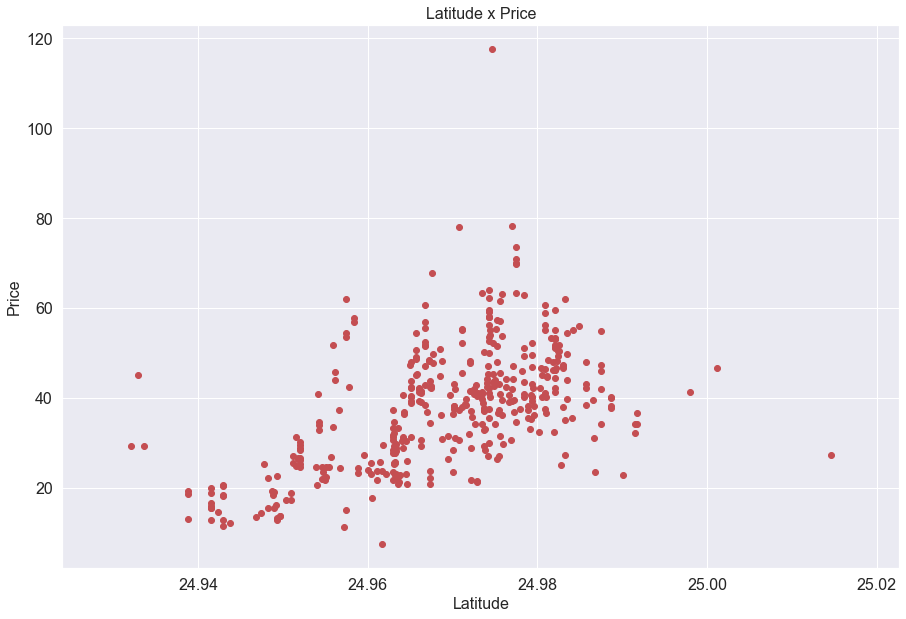

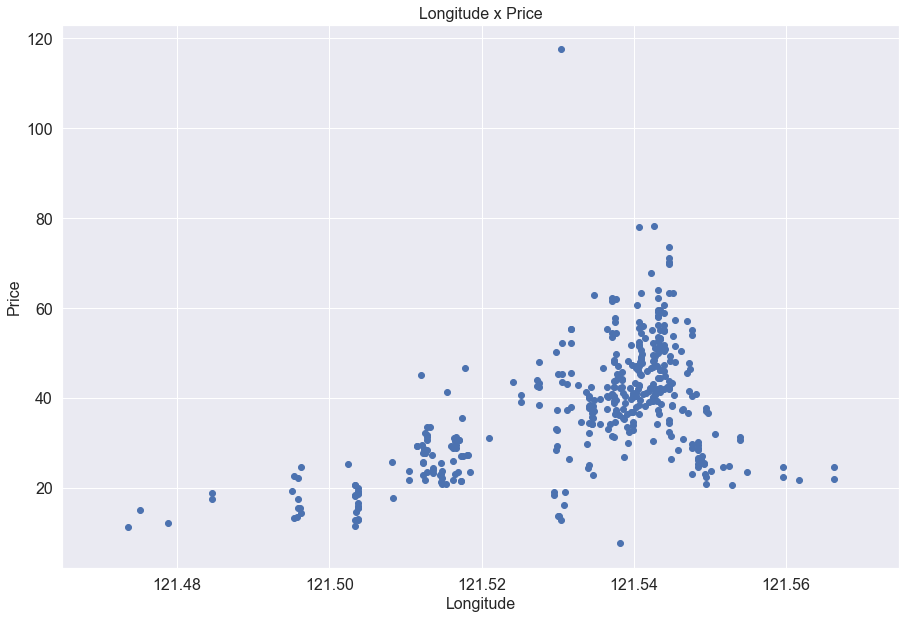

In [38]:
# fem la latitude
plt.figure(figsize=(15,10))
plt.scatter(x=X_ren['latitude'], y=y_ren['y_price'], c='r')
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Latitude x Price', fontsize=16)

# fem la longitude
plt.figure(figsize=(15,10))
plt.scatter(x=X_ren['longitude'], y=y_ren['y_price'], c='b')
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Longitude x Price', fontsize=16)
plt.show()

Veiem el mateix que havíem previst, tant la latitude i sobretot la longitude tenen impacte en el preu final dels habitatges. 

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Quins atributs tenen correlació positiva? Quins negativa? Quins no tenen correlació? Analitza cadascun dels gràfics. Té sentit que la relació de l'atribut amb el target sigui aquesta?
</div>

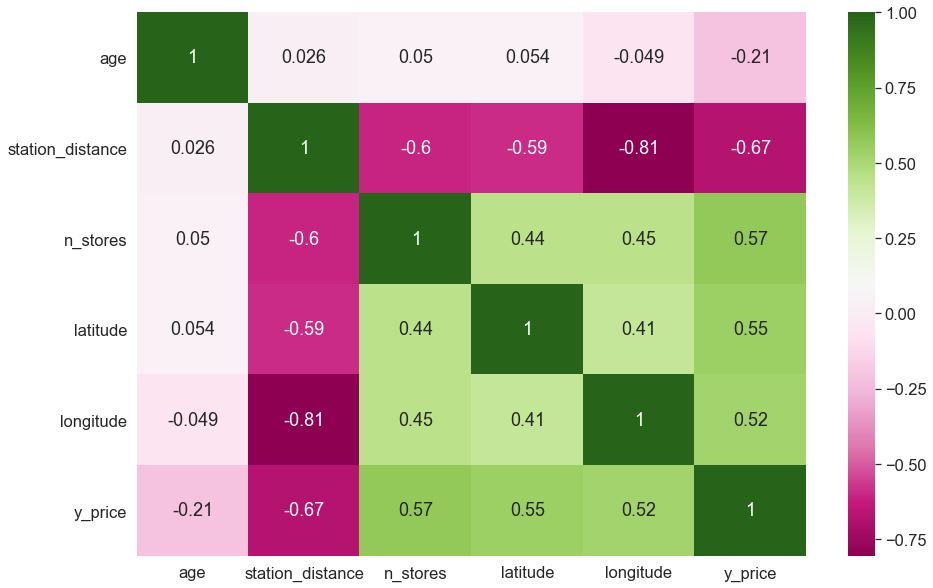

In [39]:
correlation_matrix = X_ren.join(y_ren).corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot = True, cmap="PiYG")
sns.set(font_scale=2)
plt.show()

Fem el mateix gràfic de correlació però ara afegim la variable de sortida y_price. Els valors verds (per sobre de 0) són correlacion positives i els liles (per sota de 0) són correlacions negatives. Quant més intens el color més forta és la correlació. Els que són més blancs (propers a 0) serien els que no tenen correlació. 

La correlació negativa indica que quan disminueix un valor augmenta l'altre. L'exemple clar és l'edat o la distància a una estació. Quan més aprop estem a una estació de metro més car és el preu. Quan menys anys té una vivenda més car és el preu.

Altres Observacions:

    - Amb la variable de sortida y_price tenim una correlació negativa amb station_distance i age. Station_distance té més correlació que age.
    - Amb la mateixa variable tenim correlació positiva en ordre de menys a més: longitude, latitude i n_stores. Les 3 amb valors molt similars.
    - La variable que té menys correlació amb la variable de sortida és age. Ja ens ho havia semblat visualment. La veritat és que sobta ja que l'edat d'un edifici acostuma a ser important. Potser la mostra és petita i no tenim vivendas molt antigues i la franja d'edat dels edificis no devalua el preu.
    - Com he comentat previament, es veu una relació forta entre station_distance i longitude. Puc entendre que pot haver un centre urbà o potser més parades de metro en una determinada posició en quant a la longitude i fà que aquestes variables estiguin fortament correlacionades.

### 2.3. Entrenament d'un model

Ara que ja tenim el dataset net i hem fet un anàlisi de les diferents variables, podem procedir a entrenar un model per tal de predir el preu d'una vivenda. Probarem amb 2 models diferents i n'interpretarem els resultats. Per començar, separem el dataset entre train i test.

<div class="alert alert-block alert-info">
    <strong>Implementació:</strong> Dividiu el <i>dataset</i> en dos subconjunts, <i>train</i> (80% de les dades) i <i>test</i> (20% de les dades). Anomeneu els conjunts: X_train, X_test, y_train, y_test. Utilitzeu l'opció random_state=24.
    
Podeu fer servir l'implementació train_test_split de sklearn.
</div>

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_ren, y_ren,  test_size=0.2, random_state=24)

Comprovem que tot estigui correcte:

In [41]:
print('Dimensions del dataset X-train: ' + str(X_train.shape))
print('Dimensions del dataset X-test: ' + str(X_test.shape))
print('Dimensions del dataset Y-train: ' + str(y_train.shape))
print('Dimensions del dataset Y-test: ' + str(y_test.shape))

Dimensions del dataset X-train: (331, 5)
Dimensions del dataset X-test: (83, 5)
Dimensions del dataset Y-train: (331, 1)
Dimensions del dataset Y-test: (83, 1)


<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Utilitza un arbre de decisió simple amb max_depth=5 per fitar el dataset sobre el conjunt de train. Dibuixa l'arbre de decisió (si et queda molt gran dibuixa'l d'un arbre entrenat amb menys profunditat perquè s'apreci bé). Utilitza alguna mesura d'error (pots escollir la que vulguis: MAE, RMSE, ...) per estimar com de bé ho ha fet el model predint en train i en test. També servirà per poder comparar a posterior amb un altre model.
    
Per dibuixar l'arbre pots guiar-te amb aquest link: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc. Towardsdatascience és un blog que et deixa llegir uns quants articles gratuïtament i després et demana subscripció. Si fos el cas i ja haguessiu arribat al límit, podeu obrir el link amb una pestanya en navegació oculta.
</div>

El primer que farem serà crear una funció per a visualitzar els errors:

In [42]:
def RegressionErrors(y_original, y_pred, type):
    mae = metrics.mean_absolute_error(y_original, y_pred)
    mse = metrics.mean_squared_error(y_original, y_pred)
    rmse = np.sqrt(mse) # or mse**(0.5)  
    r2 = metrics.r2_score(y_original,y_pred)

    print("Resultats dels errors de la regressió en el dataset de " + type + ": ")
    print("MAE:",round(mae,3))
    print("MSE:", round(mse,3))
    print("RMSE:", round(rmse,3))
    print("R-Squared:", round(r2,3))

- MAE: és la més simple i fa la mitja de les diferencies entre el predit i el real.
- MSE: penalitza els errors grans de predicció.
- RMSE: igual que MSE però en la mètrica de sortida 'y'.
- R-Squared: ens diu que tant bé expliquen els atributs (o variables independents) la variabilitat en la variable depenent o de sortida.

In [43]:
# generem el model i l'entrenem amb els paràmetres que ens diu l'enunciat
model = DecisionTreeRegressor(max_depth=5)
model_fitted = model.fit(X_train, y_train)

print("La qualitat del model d'entrenament és de: {}".format(round(model_fitted.score(X_train, y_train),3)))
print("La qualitat del model de test és de: {}".format(round(model_fitted.score(X_test, y_test),3)))

La qualitat del model d'entrenament és de: 0.862
La qualitat del model de test és de: 0.73


Aquest score retorna el valor de R2 (R-Squared) o bondat de l'ajust. És el porcentatge de la varianá de la variable depenent (y_price) que explica el nostre model. Com més propera a 1 millor. Tenim valors relativament bons encara que el de test és menor.

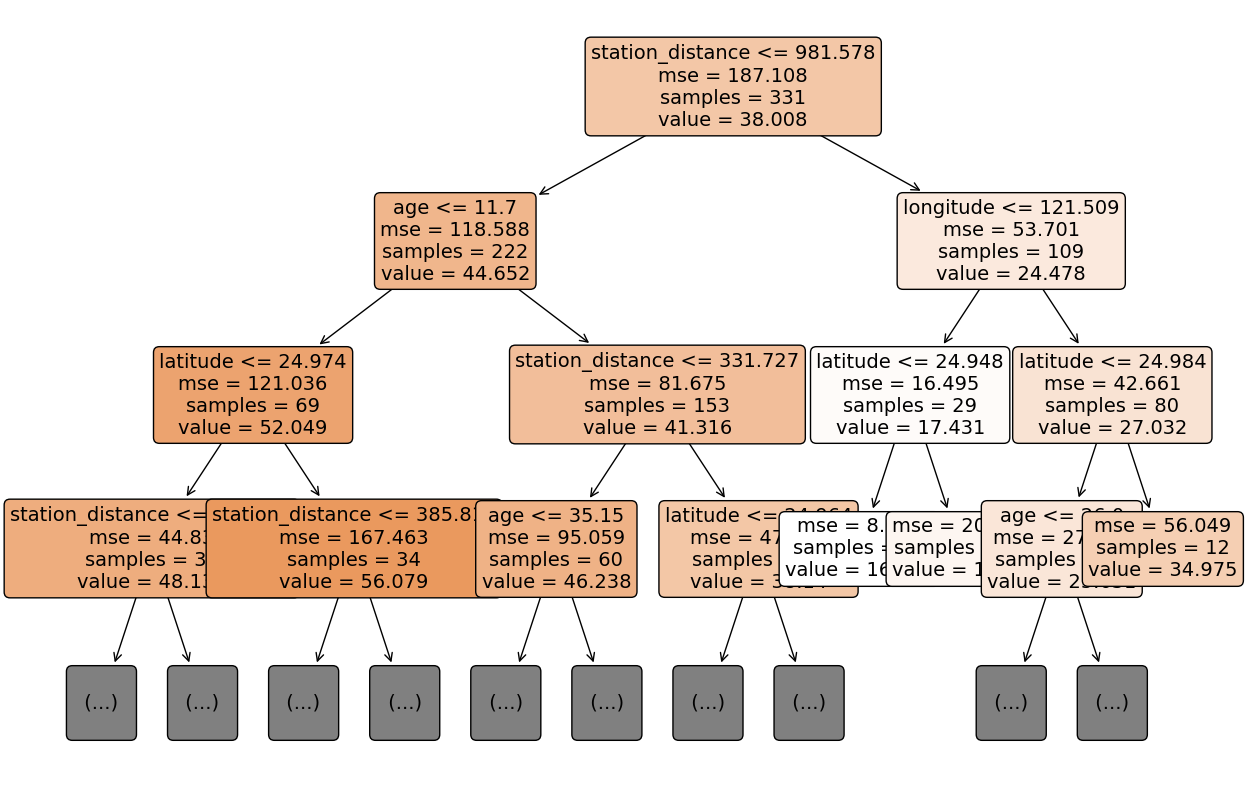

In [81]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(model,feature_names=X_train.columns,                
                   filled=True,fontsize=14, max_depth=3, rounded=True)

In [45]:
y_pred = model_fitted.predict(X_train)
RegressionErrors(y_train,y_pred, 'Train')

Resultats dels errors de la regressió en el dataset de Train: 
MAE: 3.839
MSE: 25.887
RMSE: 5.088
R-Squared: 0.862


Veiem que el model ens explica un 86% de la variança de la sortida. És un valor prou bó però hem de tenir en compte que és el model d'entrenament.

Tenim en canvi un RMSE de més de 5, per tant tenim desviacions relativament grans tenint en compte que la mitja y_price és de quasi 38. **Els valors molt per sobre o sota d'aquest RMSE poden ser vivendes que estan fora de preu de mercat.**



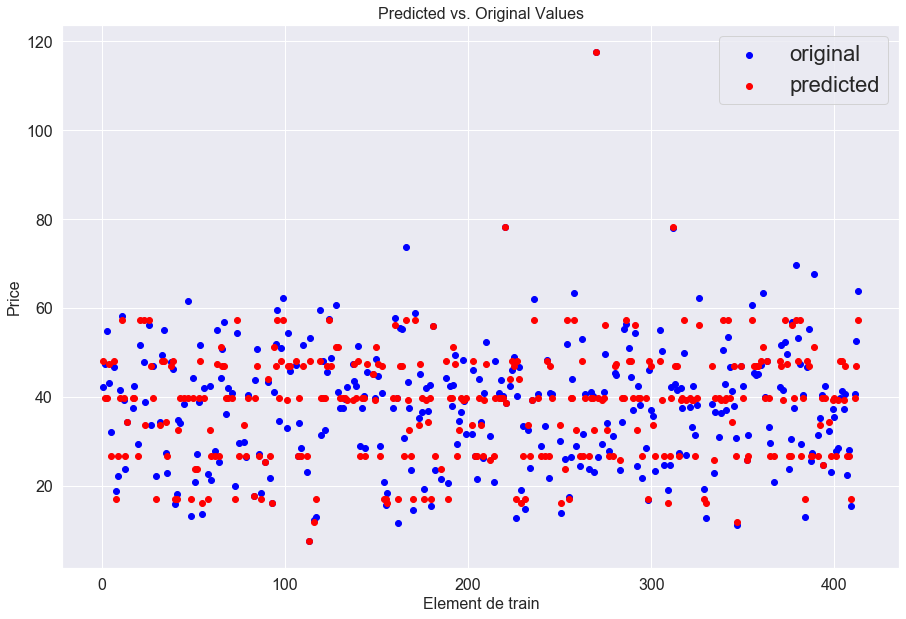

In [46]:
plt.figure(figsize=(15,10))
plt.scatter(list(y_train.index.values), y_train, color="blue", label="original")
plt.scatter(list(y_train.index.values), y_pred, color="red", label="predicted")
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Element de train', fontsize=16)
plt.title('Predicted vs. Original Values', size=16)
plt.legend()
plt.show() 

Visualment podem apreciar alguna concordancia o aproximació entre els punts originals i els predits. Aquest plot ens surten tots els punts molt aproximats al eix-X perquè tenim un outlier en el model que ens ha caigut en el model de train.

In [47]:
y_pred = model_fitted.predict(X_test)
RegressionErrors(y_test,y_pred, 'Test')

Resultats dels errors de la regressió en el dataset de Test: 
MAE: 5.048
MSE: 47.276
RMSE: 6.876
R-Squared: 0.73


La variança explicada del model baixa a 0.73, per tant podriem dir que el model té overfitting però no és excessiu. Si augmentéssim la profunditat de l'arbre la precissió del model de train seria millor però no el de test i llavors l'overfitting seria molt més clar.

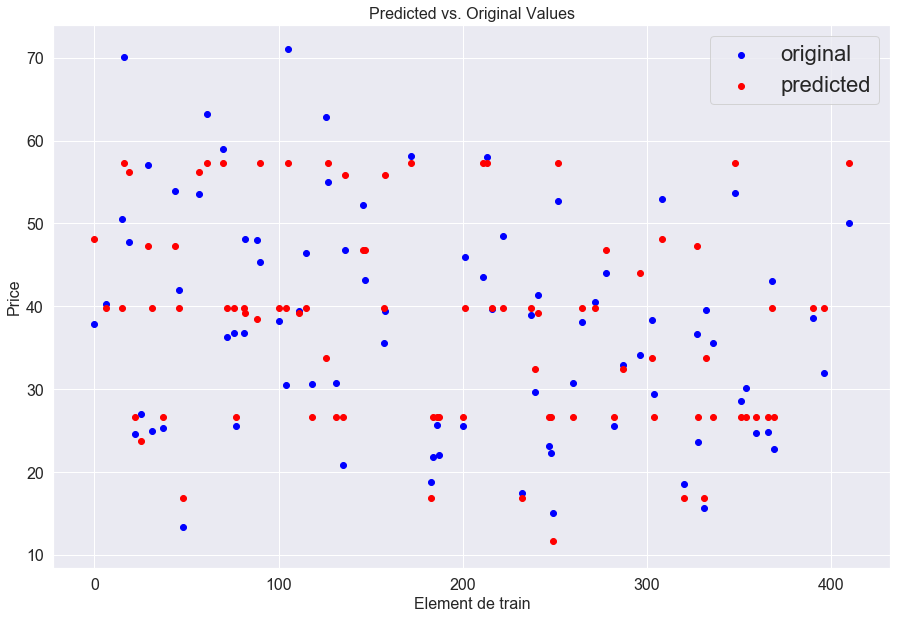

In [48]:
plt.figure(figsize=(15,10))
plt.scatter(list(y_test.index.values), y_test, color="blue", label="original")
plt.scatter(list(y_test.index.values), y_pred, color="red", label="predicted")
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel('Price', fontsize=16)
plt.xlabel('Element de train', fontsize=16)
plt.title('Predicted vs. Original Values', size=16)
plt.legend()
plt.show() 

El que s'observa en els dos plots on comparem els punts és que en les prediccions mitjançant arbres tenim la posició de l'eix Y fragmentada en diferents nivells, es tracten dels valors que donen cada una de les fulles finals i no hi han moltíssimes. També veiem que hi han valors que la predicció és molt bona i altres on tenim desviació. Aquesta desviació com hem comentat poden ser vivendes que están fora de preu de mercat.

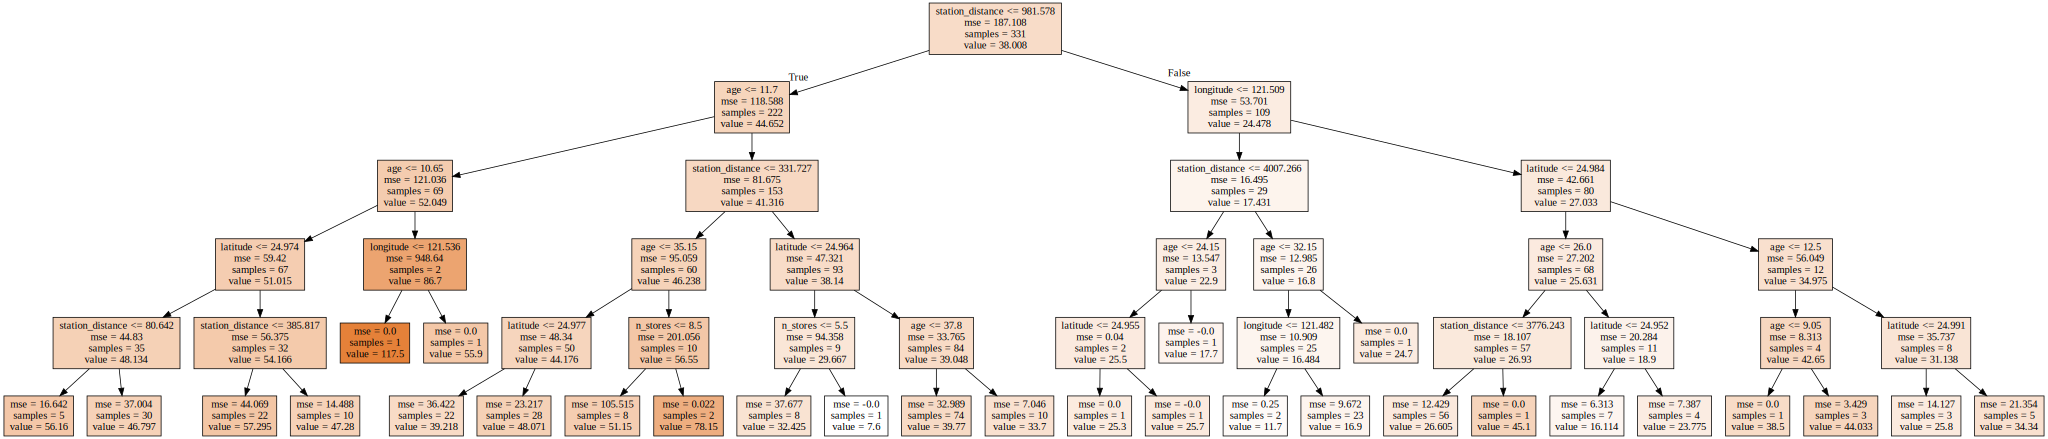

In [49]:
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=X_train.columns,  
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Interpreta l'arbre de decisió, quines són les variables que han tingut més pes? Has obtingut una bona precisió evaluant en test? S'ha produit overfitting?
</div>

Hem fet un primer plot dels tres primers nivells de profunditat i posteriorment un altre amb tot l'arbre. 

Observacions:
    
    - Revisant l'arbre veiem que l'arrel (el primer element discriminador) és station_distance. Té força sentit ja que és l'atribut que més impacte té sobre la sortida. Edat i longitud són els següents en realitzar grans particions. Longitud ja ho havíem al heatmap però l'edat el heatmap ens deia que tenia menys impacte. 
    - La intensitat del color de cada fulla ens indica  el valor de preu de la vivenda (unit price). Com més intens, més alt és el valor.
    - Podem veure que les vivendes amb una distància a estació de metro per sobre del kilometre aproximadament ja es devaluen força. Seria la part dreta de l'arbre des de el primer nivell.
    - Si ens endinsem en fulles internes també veiem que la latitude és un bon discriminador. Per sota de 25 aproximadament hi ha un tall respecte al preu.
    - L'edat està implicada amb diferents valors en força nodes i el mateix passa amb n_stores.
    
Personalment penso que tenim bona precissió amb el test relativament bona. Apart crec que s'ha produït poc overfitting, amb un R-squared en el train de 0.86 per els 0.73 en el de test.

 Segurament aplicant gradient boosting o random forest podriem millorar aquest error. 

**Bonus**: intentem optimitzar el valor de max-depth per veure si podem millorar l'arbre fent servir GridSearchCV tal i com hem fet a l'exercici 1.

In [50]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = DecisionTreeRegressor()

# Definim els hiperparàmetres
hiperparameters = [{'max_depth': [4,5,6,7,8,9,10,50,100,1000]}]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, return_train_score=True, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))

Millor score: 0.5373831841399683
Millor estimador: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Millors paràmetres: {'max_depth': 9}


In [51]:
model = DecisionTreeRegressor(max_depth=1000)
model_fitted = model.fit(X_train, y_train)

y_pred = model_fitted.predict(X_train)
RegressionErrors(y_train,y_pred, 'Train')

y_pred = model_fitted.predict(X_test)
RegressionErrors(y_test,y_pred, 'Test')

Resultats dels errors de la regressió en el dataset de Train: 
MAE: 0.46
MSE: 2.077
RMSE: 1.441
R-Squared: 0.989
Resultats dels errors de la regressió en el dataset de Test: 
MAE: 5.832
MSE: 63.991
RMSE: 7.999
R-Squared: 0.634


Hem aconseguit un millor valor en el conjunt de train, 0.989, però el de test és de 0.642. Tenim molt més overfitting

Mostrem la millora en la predicció en el model de train conforme augmentem el valor de max_depth. Però també podem veure clarament com el overfitting també augmenta. Amb el gràfic podríem dir que la millor iteració és la 5 que té millor score amb menys overfitting.

El motiu és que el criteri que fà servir per defecte GridSearchCV és MSE que recordem que és l'arrel quadrara de RMSE però no té en compte l'overfitting. 

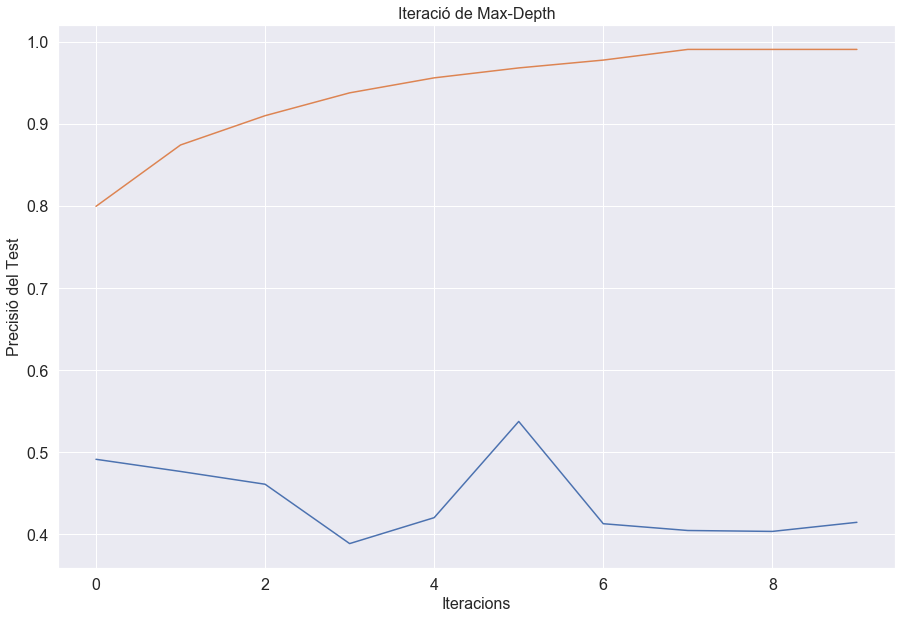

In [52]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 
plt.figure(figsize=(15,10))
plt.title('Iteració de Max-Depth', fontsize=16)
plt.xlabel('Iteracions', fontsize=16)
plt.ylabel('Precisió del Test', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

**Bonus**: fem un càlcul per optimitzar l'arbre segons min_samples_leaf. 

El paràmetre min_samples_leaf verifica abans que es generi el node, és a dir, si la possible divisió dóna com a resultat un fill amb menys mostres, s'evitarà la divisió i serà una fulla.

In [53]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = DecisionTreeRegressor()

# Definim els hiperparàmetres:
hiperparameters = {"min_samples_leaf":[1,2,3,10,25,50,100]}

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, return_train_score=True, cv=4)
grid.fit(X_train, y_train)

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))

Millor score: 0.6249806666005352
Millor estimador: DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')
Millors paràmetres: {'min_samples_leaf': 10}


In [54]:
model = DecisionTreeRegressor(min_samples_leaf=10)
model_fitted = model.fit(X_train, y_train)

y_pred = model_fitted.predict(X_train)
RegressionErrors(y_train,y_pred, 'Train')

print()

y_pred = model_fitted.predict(X_test)
RegressionErrors(y_test,y_pred, 'Test')

Resultats dels errors de la regressió en el dataset de Train: 
MAE: 4.19
MSE: 38.853
RMSE: 6.233
R-Squared: 0.792

Resultats dels errors de la regressió en el dataset de Test: 
MAE: 4.795
MSE: 48.572
RMSE: 6.969
R-Squared: 0.722


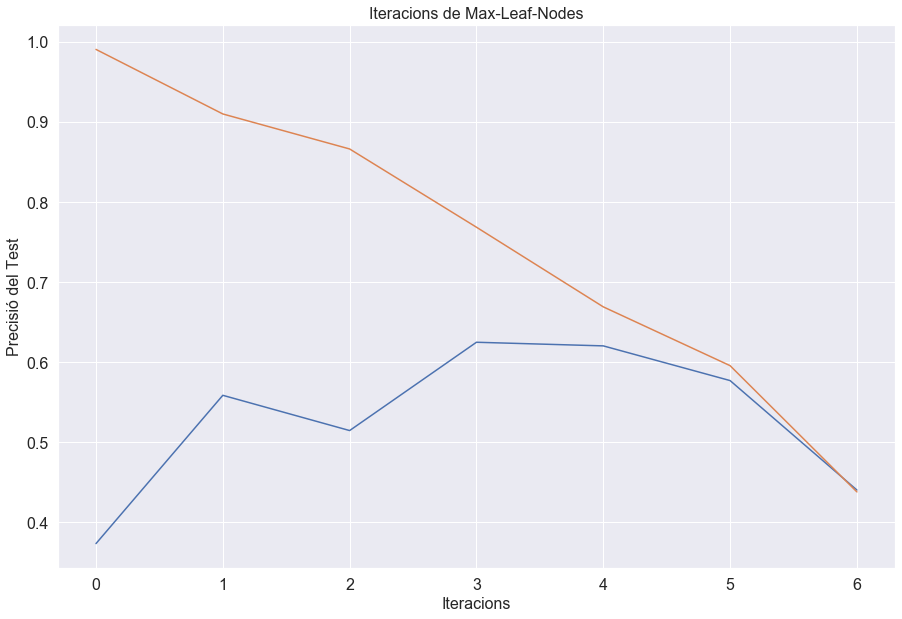

In [55]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score'] 
plt.figure(figsize=(15,10))
plt.title('Iteracions de Max-Leaf-Nodes', fontsize=16)
plt.xlabel('Iteracions', fontsize=16)
plt.ylabel('Precisió del Test', fontsize=16)
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

En aquest model hem millorat l'overfitting en detriment de la qualitat del test però realment és millor model que els altres ja que la qualitat del R-squared en el model de test és millor i tenim menor overfitting.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Utilitza Random Forest o Gradient Boosting per fitar el dataset. Aquesta vegada anem a optimitzar el model per obtenir els millors resultats possibles. Tal i com hem vist a l'exercici anterior, recorda seguir els següents passos:
    
  - Utilitzar el dataset de train per trobar els millors hiperparàmetres fent cross-validation.
  - Entrenar el model amb train, predir amb train i test i calcular-ne l'error (MAE, RMSE, ...)
</div>

### Random Forest:

In [56]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = RandomForestRegressor()

hiperparameters = [
    {'max_depth': list(np.arange(3, 10)), 
     'n_estimators': [5] + list(np.arange(10, 100, 5)),     
    }
]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, cv=4, return_train_score=True)
grid.fit(X_train, np.ravel(y_train))

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()

Millor score: 0.6855067857185606
Millor estimador: RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
Millors paràmetres: {'max_depth': 9, 'n_estimators': 30}



Resultats dels errors de la regressió en el dataset de Train: 
MAE: 2.464
MSE: 13.973
RMSE: 3.738
R-Squared: 0.925

Resultats dels errors de la regressió en el dataset de Test: 
MAE: 4.392
MSE: 37.818
RMSE: 6.15
R-Squared: 0.784


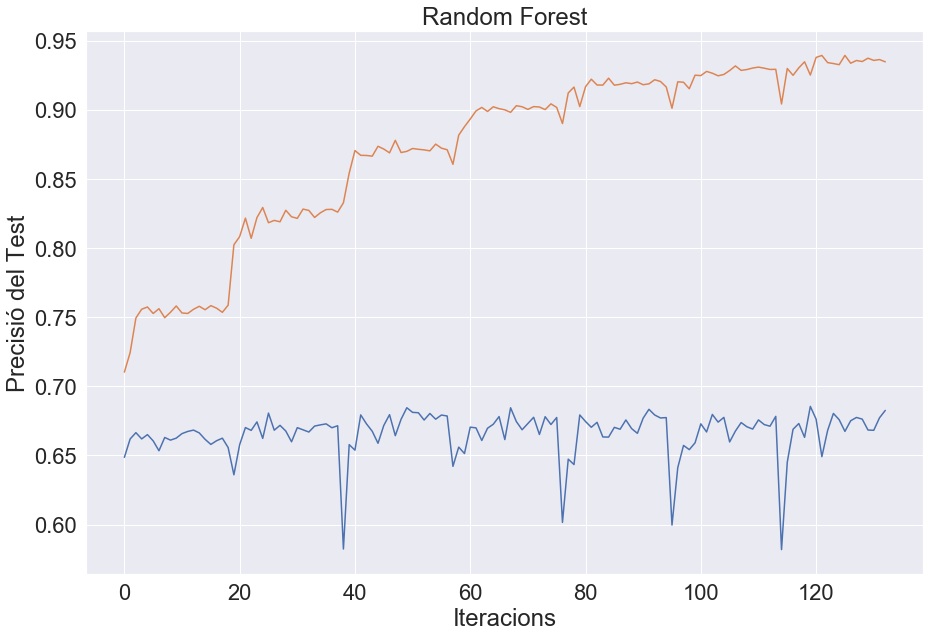

In [57]:
model_forest = RandomForestRegressor(max_depth=9, n_estimators=30)
model_forest_fitted = model_forest.fit(X_train, np.ravel(y_train))

y_pred = model_forest_fitted.predict(X_train)
RegressionErrors(y_train,y_pred, 'Train')

print()

y_pred = model_forest_fitted.predict(X_test)
RegressionErrors(y_test,y_pred, 'Test')

test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

plt.figure(figsize=(15,10))
plt.title('Random Forest')
plt.xlabel('Iteracions')
plt.ylabel('Precisió del Test')
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.show()

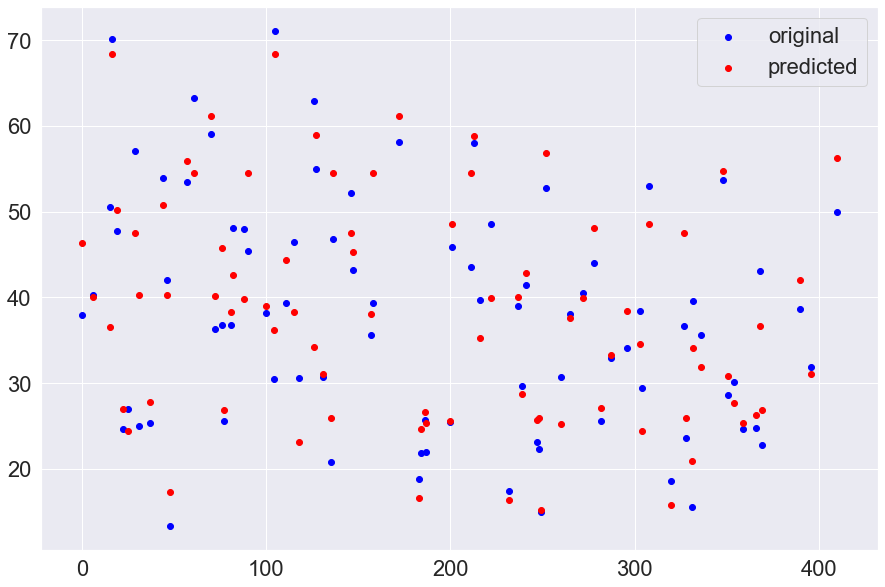

In [58]:
plt.figure(figsize=(15,10))
plt.scatter(list(y_test.index.values), y_test, color="blue", label="original")
plt.scatter(list(y_test.index.values), y_pred, color="red", label="predicted")
plt.legend()
plt.show() 

Tenim una molt bona predicció en el model de test i en el d'entrenament hem arribat quasi al 80%. Realment el guany en amb aquest algoritme és evident encara que amb els valors seguim tenint overfitting. Veiem clarament que els resultats (predicted) no estan com estratificats ja que tenim força més fulles en els nodes finals. 

Un Random Forest / Gradient Boosting no és tant fàcil d'interpretar com un simple Decision Tree. No podem dibuixar l'arbre, perquè són combinacions de molts arbres, però si que podem saber quines han estat les variables més decisives a l'hora de generar el model. Per saber-ho, no podem fer-ho a ull mirant com es divideix l'arbre, sinó que ho podem consultar al model mitjançant la "feature importance" d'aquest.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> Mostra cada variable del model fitat, juntament amb la seva feature importance.
</div>

[0.18562643 0.60354423 0.02384284 0.10104848 0.08593801]


<BarContainer object of 5 artists>

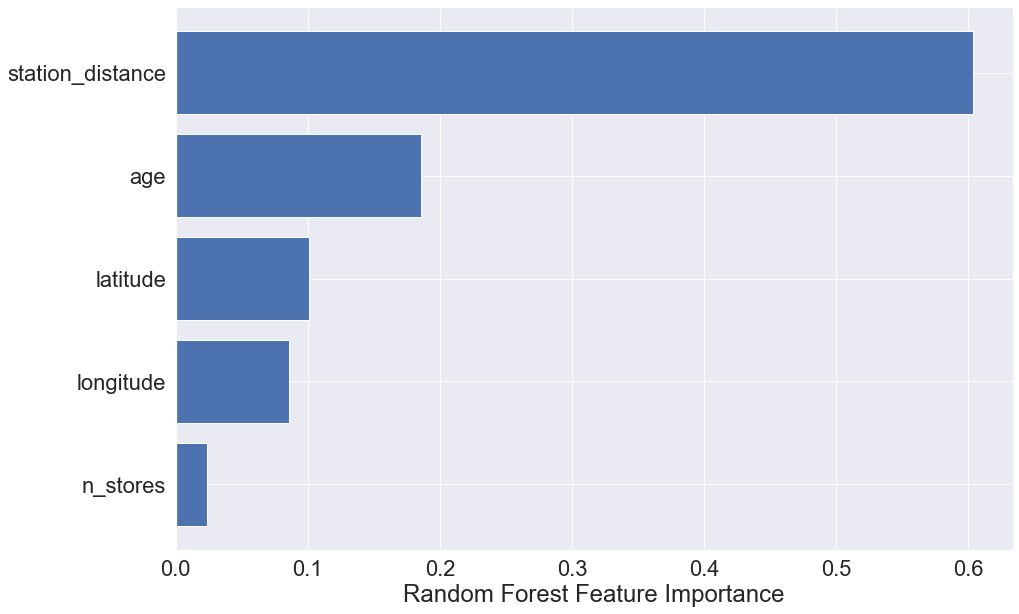

In [59]:
print(model_forest_fitted.feature_importances_)

plt.figure(figsize=(15,10))
sorted_idx = model_forest.feature_importances_.argsort()
plt.xlabel("Random Forest Feature Importance")
plt.barh(X_train.columns[sorted_idx], model_forest_fitted.feature_importances_[sorted_idx])

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Interpreta el classificador, quines són les variables que han tingut més pes? Has obtingut una bona precisió evaluant en test? S'ha produit overfitting?
</div>

Tal i com havíem vist en l'arbre de classificació 'simple', la variable més important és station_distance seguida de lluny de age. Després venen les altres tres tenint present que la que menys pes te és n_stores. Ens quadra força amb el grid que haviem creat per veure la correlació de les variables amb la sortida y excepte amb age que ens segueix sense quadrar. El heatmap que haviem creat li donava molt menys pes.

Com he comentat, el model no ha millorat moltíssim en test. Seguim tenint un error en la predicció (RMSE) de 6 unitats quan la mitja de la sortida és de 38 aproximadament. També tenim overfitting encara que menys.

### Gradient Boosting: ###

Anem a realitzar el mateix procés però amb Gradient Boosting a veure si podem millorar encara més el resultat.

In [60]:
# per obtenir el mateix resultat per l'entrega
np.random.seed(1234)

# Definim l'algoritme
algorithm = GradientBoostingRegressor()

# Definim els hiperparàmetres
hiperparameters = [{'learning_rate': [0.01,0.1,1], 'n_estimators': [10,50,100]}]

# Per cercar els millors hiperparàmetres
grid = GridSearchCV(estimator=algorithm, param_grid=hiperparameters, return_train_score=True, cv=4)
grid.fit(X_train, np.ravel(y_train))

# Mostrem els millors valors d'hiperparàmetres
print("Millor score: " + str(grid.best_score_))
print("Millor estimador: " + str(grid.best_estimator_))
print("Millors paràmetres: " + str(grid.best_params_))
print()
print("Grid de scores:")
print()
means = grid.cv_results_["mean_test_score"]
stds = grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

Millor score: 0.6924242654759739
Millor estimador: GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=50,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Millors paràmetres: {'learning_rate': 0.1, 'n_estimators': 50}

Grid de scores:

0.119 (+/-0.039) for {'learning_rate': 0.01, 'n_estimators': 10}
0.417 (+/-0.130) for {'learning_rate': 0.01, 'n_estimators': 50}
0.570 (+/-0.166) for {'learning_rate': 0.01, 'n_estimators': 100}
0.579 (

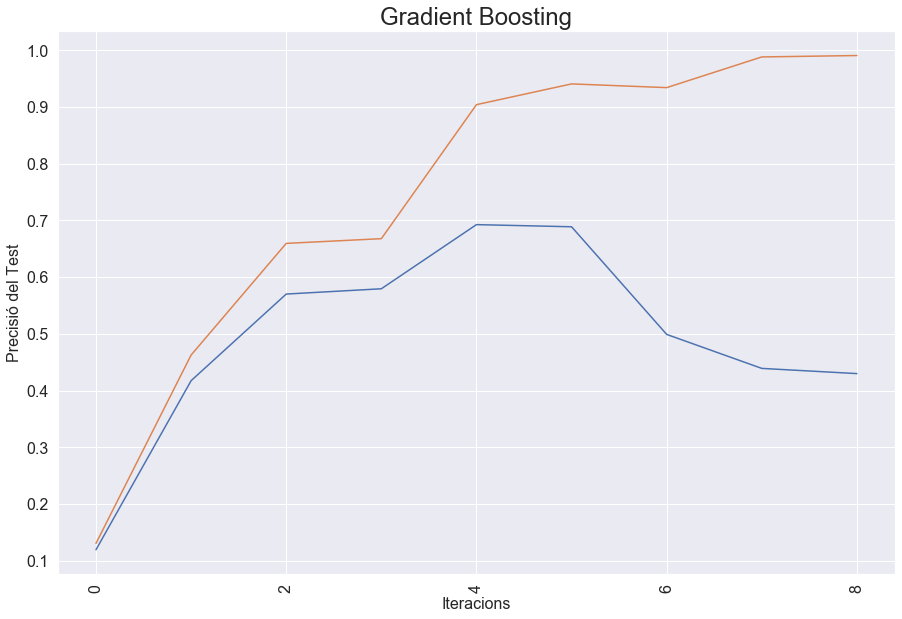

In [61]:
test_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

plt.figure(figsize=(15,10))
plt.title('Gradient Boosting', )
plt.xlabel('Iteracions', fontsize=16)
plt.ylabel('Precisió del Test', fontsize=16)
plt.xticks(np.arange(0, 81, 2), fontsize=16, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1),fontsize=16)
plt.plot(test_scores, label='test')
plt.plot(train_scores, label='train')
plt.show()

In [62]:
# per obtenir el mateix resultat per l'entrega
model_boosting = GradientBoostingRegressor(learning_rate=0.1,n_estimators=50)
model_boosting_fitted = model_boosting.fit(X_train, np.ravel(y_train))

y_pred = model_boosting_fitted.predict(X_train)
RegressionErrors(y_train,y_pred, 'Train')

y_pred = model_boosting_fitted.predict(X_test)
RegressionErrors(y_test,y_pred, 'Test')

Resultats dels errors de la regressió en el dataset de Train: 
MAE: 3.448
MSE: 20.966
RMSE: 4.579
R-Squared: 0.888
Resultats dels errors de la regressió en el dataset de Test: 
MAE: 4.096
MSE: 35.275
RMSE: 5.939
R-Squared: 0.798


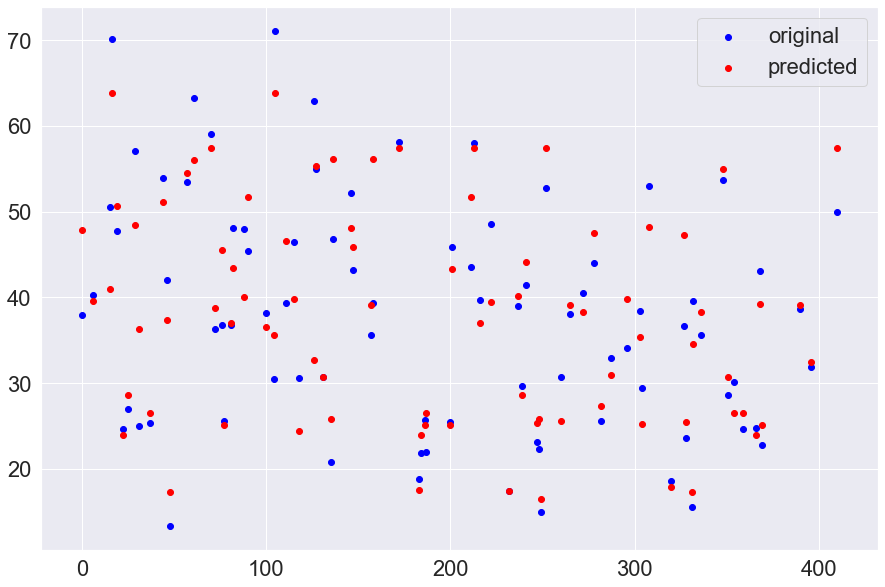

In [63]:
plt.figure(figsize=(15,10))
plt.scatter(list(y_test.index.values), y_test, color="blue", label="original")
plt.scatter(list(y_test.index.values), y_pred, color="red", label="predicted")
plt.legend()
plt.show() 

Amb Gradient Boosting tenim un model amb la millor precissió en el model de test i amb el menor overfitting. Agafem aquest model com el més vàlid.

### 2.4. Predicció de casos nous

Fins ara hem entrenat un model i hem evaluat en test per fer-nos una idea de la precisió del nostre model amb dades reals. Ara anem a utilitzar-lo.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> 
    
  - Cas 1: Volem comprar una vivenda que està situada a 1km de l'estació de tren, concretament aquestes són les seves coordenades: 24.87745, 121.31683. La vivenda té 3 botigues properes i es va construir fa 15 anys. Es ven per 24.5, volem saber si està per sobre o per sota el preu de mercat.	
    
  - Cas 2: Som una empresa que es dedica a fer negoci compran pisos barats, arreglant-los i re-venentlos més cars. Volem saber quines vivendes es venen per sota del seu preu de mercat ("chollos") per poder comprar-les i revendre-les en un futur.
</div>

### Cas1: Compra de vivenda

**Prerequisits:**

    - station_distance: 1000
    - latitude: 24.87745
    - longitude: 121.31683
    - n_stores: 3
    - age: 15

Realitzem la predicció a partir del model generat amb Gradient Boosting:

In [71]:
Xnew = [[15,1000,3,24.87745,121.31683]]

units = round(model_boosting_fitted.predict(Xnew)[0],2)
print("Predicció amb Gradient Boosting: "+ str(units))

Predicció amb Gradient Boosting: 31.44


Segons el nostre model el pis s'ha venut a un preu molt semblant al preu de mercat ja que tenim una predicció de 31.44 i s'ha venut a 24.5. S'ha venut per sota del preu predit per el model.

### Cas2: Cerca de vivendes per sota preu de mercat

Per a cercar les vivendas per sota de preu de mercat anem a comparar la predicció del nostre model respecte el valor de venta del dataset. Nosaltres amb el model generat farem una valoració del preu de les vivendes segons les característiques però segurament al dataset tenim alguns valors que estaran allunyats per baix (i podem fer servir com a ofertes) o per dalt (estan inflats de preu). 

Realitzem la predicció a partir del model generat amb Gradient Boosting.

In [75]:
# agafem el model sencer i fem la predicció
y_pred = model_boosting.predict(X_ren)
# mostrem la qualitat del model totes les dades
RegressionErrors(y_ren,y_pred, 'Complete')

# calculem la diferencia entre els valors del nostre model i el valor original
differences = []
idx = 0
for index, row in y_ren.iterrows():
    difference = row['y_price'] - y_pred[idx]
    differences.append(round(difference, 2))
    idx = idx+1 

# al dataset afegim el preu, la predicció i la diferencia
df_opportunities = X_ren.join(pd.DataFrame(y_ren, columns=['y_price']))
df_opportunities = df_opportunities.join(pd.DataFrame(y_pred, columns=['y_pred']))
df_opportunities = df_opportunities.join(pd.DataFrame(differences, columns=['difference']))

Resultats dels errors de la regressió en el dataset de Complete: 
MAE: 3.578
MSE: 23.835
RMSE: 4.882
R-Squared: 0.871


Tenim una bondat del model de quasi el 90% (0.871) perque estem fent servir tant el model de train com el de test.

Ara que ja tenim les prediccions anem a veure els valors a nivell estadístic.

In [73]:
df_opportunities.describe()

,age,station_distance,n_stores,latitude,longitude,y_price,y_pred,difference
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193,38.002423,-0.022198
std,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488,11.911741,4.887898
min,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000,15.037091,-16.720000
25%,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000,27.390756,-2.950000
50%,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000,39.011587,-0.275000
75%,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000,47.624238,2.630000
max,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000,91.761873,30.220000


Podem veure que el valor de la mitja en y_price i y_pred és molt similar i la diferència és al voltant de 0. Per tant, podriem dir que el model fa una bona predicció. La desviació estàndard coincideix amb RMSE, al final l'error quadràtic mitjà mesura la quantitat d'error entre dos conjunts de dades, és a dir, compara el valor predit i el valor de la mostra original.

Ara per veure els pisos 'xollos' ordenarem el dataset per la diferencia en ordre ascendent. Tindrem els valors negatius de la diferència. Aquests valors negatius ens diuen que el preu del model és superior al preu de venda amb el que s'estan venent per sota del preu de mercat. Els valors positiud són pisos per sobre del seu valor de mercat.

In [74]:
df_opportunities.sort_values(by=['difference'], ascending=True)

,age,station_distance,n_stores,latitude,longitude,y_price,y_pred,difference
158,11.6,390.5684,5,24.97937,121.54245,39.4,56.115302,-16.72
256,14.6,339.2289,1,24.97519,121.53151,26.5,40.214521,-13.71
113,14.8,393.2606,6,24.96172,121.53812,7.6,21.183411,-13.58
31,29.6,769.4034,7,24.98281,121.53408,25.0,36.284103,-11.28
333,7.8,104.8101,5,24.96674,121.54067,38.4,49.571124,-11.17
...,...,...,...,...,...,...,...,...
312,35.4,318.5292,9,24.97071,121.54069,78.0,64.667076,13.33
47,35.9,640.7391,3,24.97563,121.53715,61.5,46.377181,15.12
220,37.2,186.5101,9,24.97703,121.54265,78.3,62.674021,15.63
270,10.8,252.5822,1,24.97460,121.53046,117.5,91.761873,25.74


Finalment, per arrodonir l'exercici, mostrem les 25 primeres vivendes que podem considerar per sota de preu de mercat. 

In [68]:
df_opportunities.sort_values(by=['difference'], ascending=True).head(n=25)

,age,station_distance,n_stores,latitude,longitude,y_price,y_pred,difference
158,11.6,390.56840,5,24.97937,121.54245,39.4,56.115302,-16.72
256,14.6,339.22890,1,24.97519,121.53151,26.5,40.214521,-13.71
113,14.8,393.26060,6,24.96172,121.53812,7.6,21.183411,-13.58
31,29.6,769.40340,7,24.98281,121.53408,25.0,36.284103,-11.28
333,7.8,104.81010,5,24.96674,121.54067,38.4,49.571124,-11.17
327,3.5,757.33770,3,24.97538,121.54971,36.7,47.286610,-10.59
345,0.0,185.42960,0,24.97110,121.53170,37.9,48.093813,-10.19
0,32.0,84.87882,10,24.98298,121.54024,37.9,47.796185,-9.90
271,17.7,451.64190,8,24.96945,121.54490,26.5,35.900271,-9.40
136,11.4,390.56840,5,24.97937,121.54245,46.8,56.115302,-9.32
